In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn import datasets

from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import smooth_img

mni152_template = datasets.load_mni152_template(resolution=1)

In [2]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids')
deriv_dir = os.path.join(project_dir, 'derivatives')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27']
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [4]:
participants_fpath

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/participants.tsv'

In [5]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT07   22   M      Mandarin  2003.0
6       sub-FLT08   23   F      Mandarin  2005.0
7       sub-FLT09   30   F  non-Mandarin  3002.0
8       sub-FLT10   23   F      Mandarin  2006.0
9       sub-FLT11   20   F  non-Mandarin  1005.0
10      sub-FLT12   20   F  non-Mandarin  3004.0
11      sub-FLT13   23   F  non-Mandarin  3005.0
12      sub-FLT14   23   M  non-Mandarin  3006.0
13      sub-FLT15   22   M      Mandarin  2010.0
14      sub-FLT17   29   F      Mandarin     NaN
15      sub-FLT18   24   M      Mandarin  2016.0
16      sub-FLT19   24   M      Mandarin  2018.0
17      sub-FLT20   26   F  non-Mandarin  3008.0
18      sub-FLT21   21   M      Mandarin  2011.0
19      sub-FLT22   

In [6]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

#### Create design matrixes

In [7]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      1     0
4      0     1
5      1     0
6      1     0
7      0     1
8      1     0
9      0     1
10     0     1
11     0     1
12     0     1
13     1     0
14     1     0
15     1     0
16     1     0
17     0     1
18     1     0
19     1     0
20     1     0
21     1     0
22     0     1
23     1     0
24     0     1
25     0     1


### Get files

In [110]:
contrast_label = 'sound'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'
model_label = 'stimulus_per_run_LSS'
mask_label = 'gm'
cond_label = 'tone'
search_radmm = 12
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)


In [111]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/mvpc-searchlight_fwhm-{fwhm}_searchmm-{search_radmm}_{model_label}*/*{cond_label}*.nii.gz'))[0] for sub_id in subjects_label]

In [112]:
l1_fnames_groupdiff

['/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/mvpc-searchlight_fwhm-0.0_searchmm-12_stimulus_per_run_LSS/sub-FLT02_fwhm-0.0_mask-gm_searchmm-12_cond-tone_map-tstat_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/mvpc-searchlight_fwhm-0.0_searchmm-12_stimulus_per_run_LSS/sub-FLT03_fwhm-0.0_mask-gm_searchmm-12_cond-tone_map-tstat_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/mvpc-searchlight_fwhm-0.0_searchmm-12_stimulus_per_run_LSS/sub-FLT04_fwhm-0.0_mask-gm_searchmm-12_cond-tone_map-tstat_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/mvpc-searchlight_fwhm-0.0_searchmm-12_stimulus_per_run_LSS/sub-FLT05_fwhm-0.0_mask-gm_s

In [113]:
from nilearn.image import threshold_img
from nilearn import surface
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

## Parametric accuracy minus chance

#### loop through images and subtract 0.25 (chance) if above chance

In [114]:
from nilearn.image import new_img_like

In [115]:
chance_acc = 0.25
diff_img_list = []

for mask_label in ['gm_cond-tone']:
    print(mask_label)
    mask_sl_thr_array = []

    for sx, sub_mask_sl_fpath in enumerate(l1_fnames_groupdiff):
        #sub_mask_sl_fpath = os.path.join(nilearn_dir, 'level-1_fwhm-1.50', '%s_space-%s'%(sub_id, space_label), search_label, 
        #                                 '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
        sub_sl_img = nib.load(sub_mask_sl_fpath)

        sub_sl_data = sub_sl_img.get_fdata()

        # subtract chance accuracies
        diff_data = sub_sl_data - chance_acc
        # if below 0, move to 0 (no such thing as negative chance)
        diff_data[diff_data < 0] = 0

        diff_img = new_img_like(sub_sl_img, diff_data)

        diff_img_list.append(diff_img)

gm_cond-tone


In [116]:
# smoothed versions (if needed)
smoothed_l1_fnames_groupdiff = smooth_img(diff_img_list, 3)

#### Mandarin-speaking participants group accuracy

In [117]:
group_label = 'Mand'

#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

In [118]:
from nilearn.image import threshold_img
threshold = 3.09
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=False,
                            )

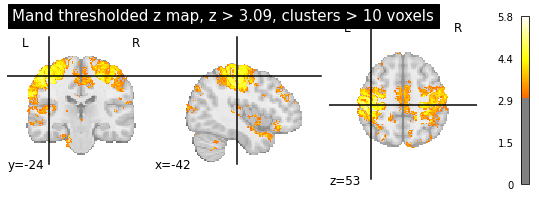

In [119]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



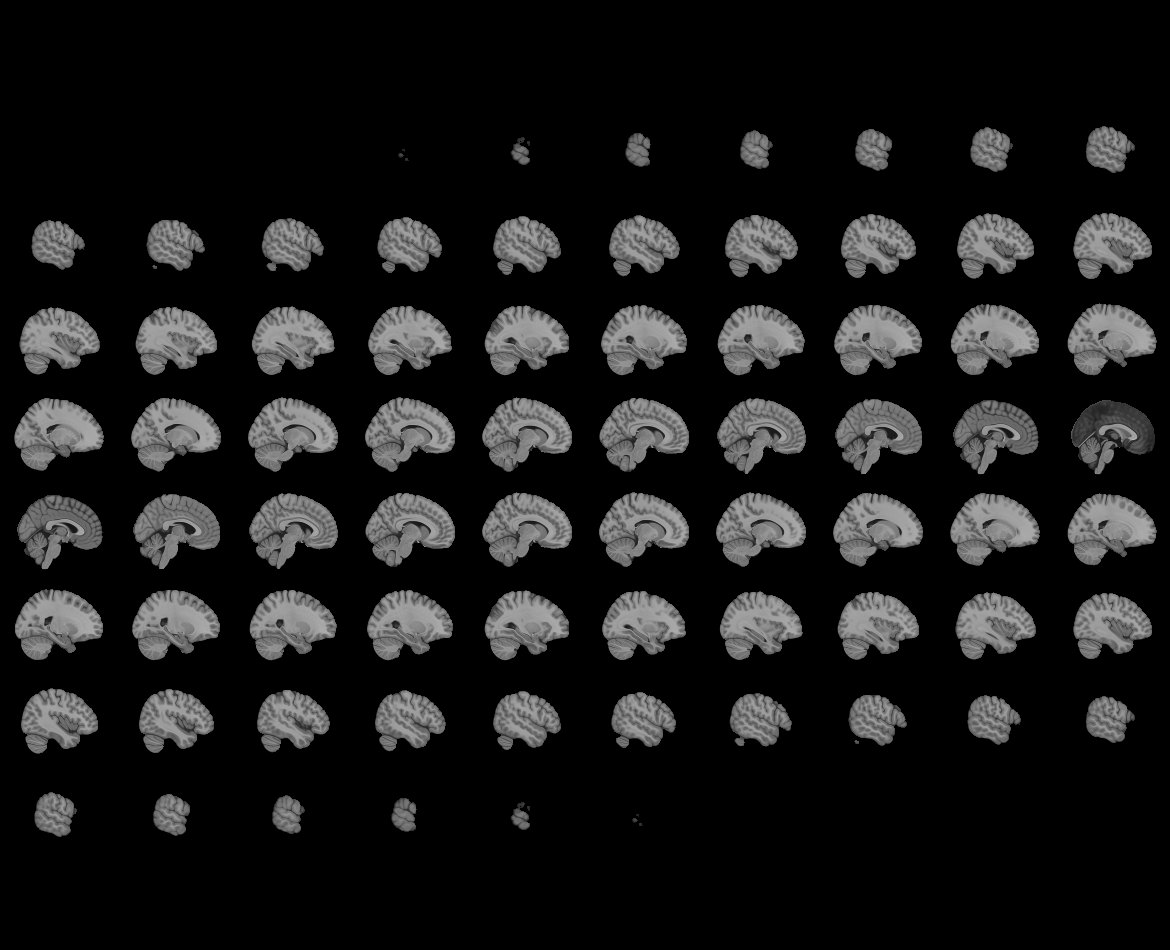
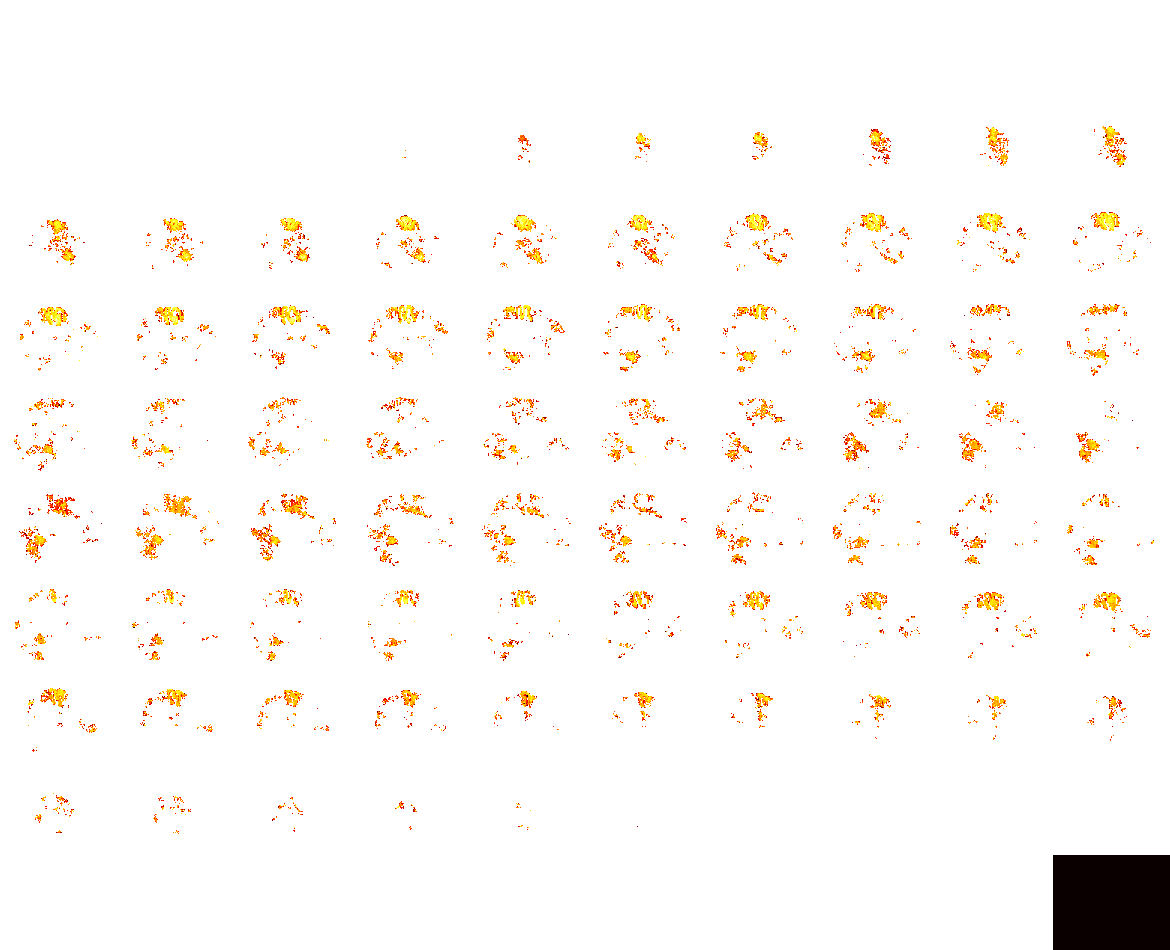

In [120]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  cmap='black_red',
                  symmetric_cmap=False)

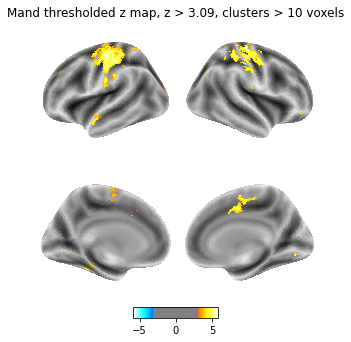

In [121]:
plotting.plot_img_on_surf(thresholded_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          inflate=True,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

file saved to  level-2_mvpc-searchlight/group-Mand_mvpc-searchlight_searchmm-12_fwhm-0.0_map-zstat_slice.png


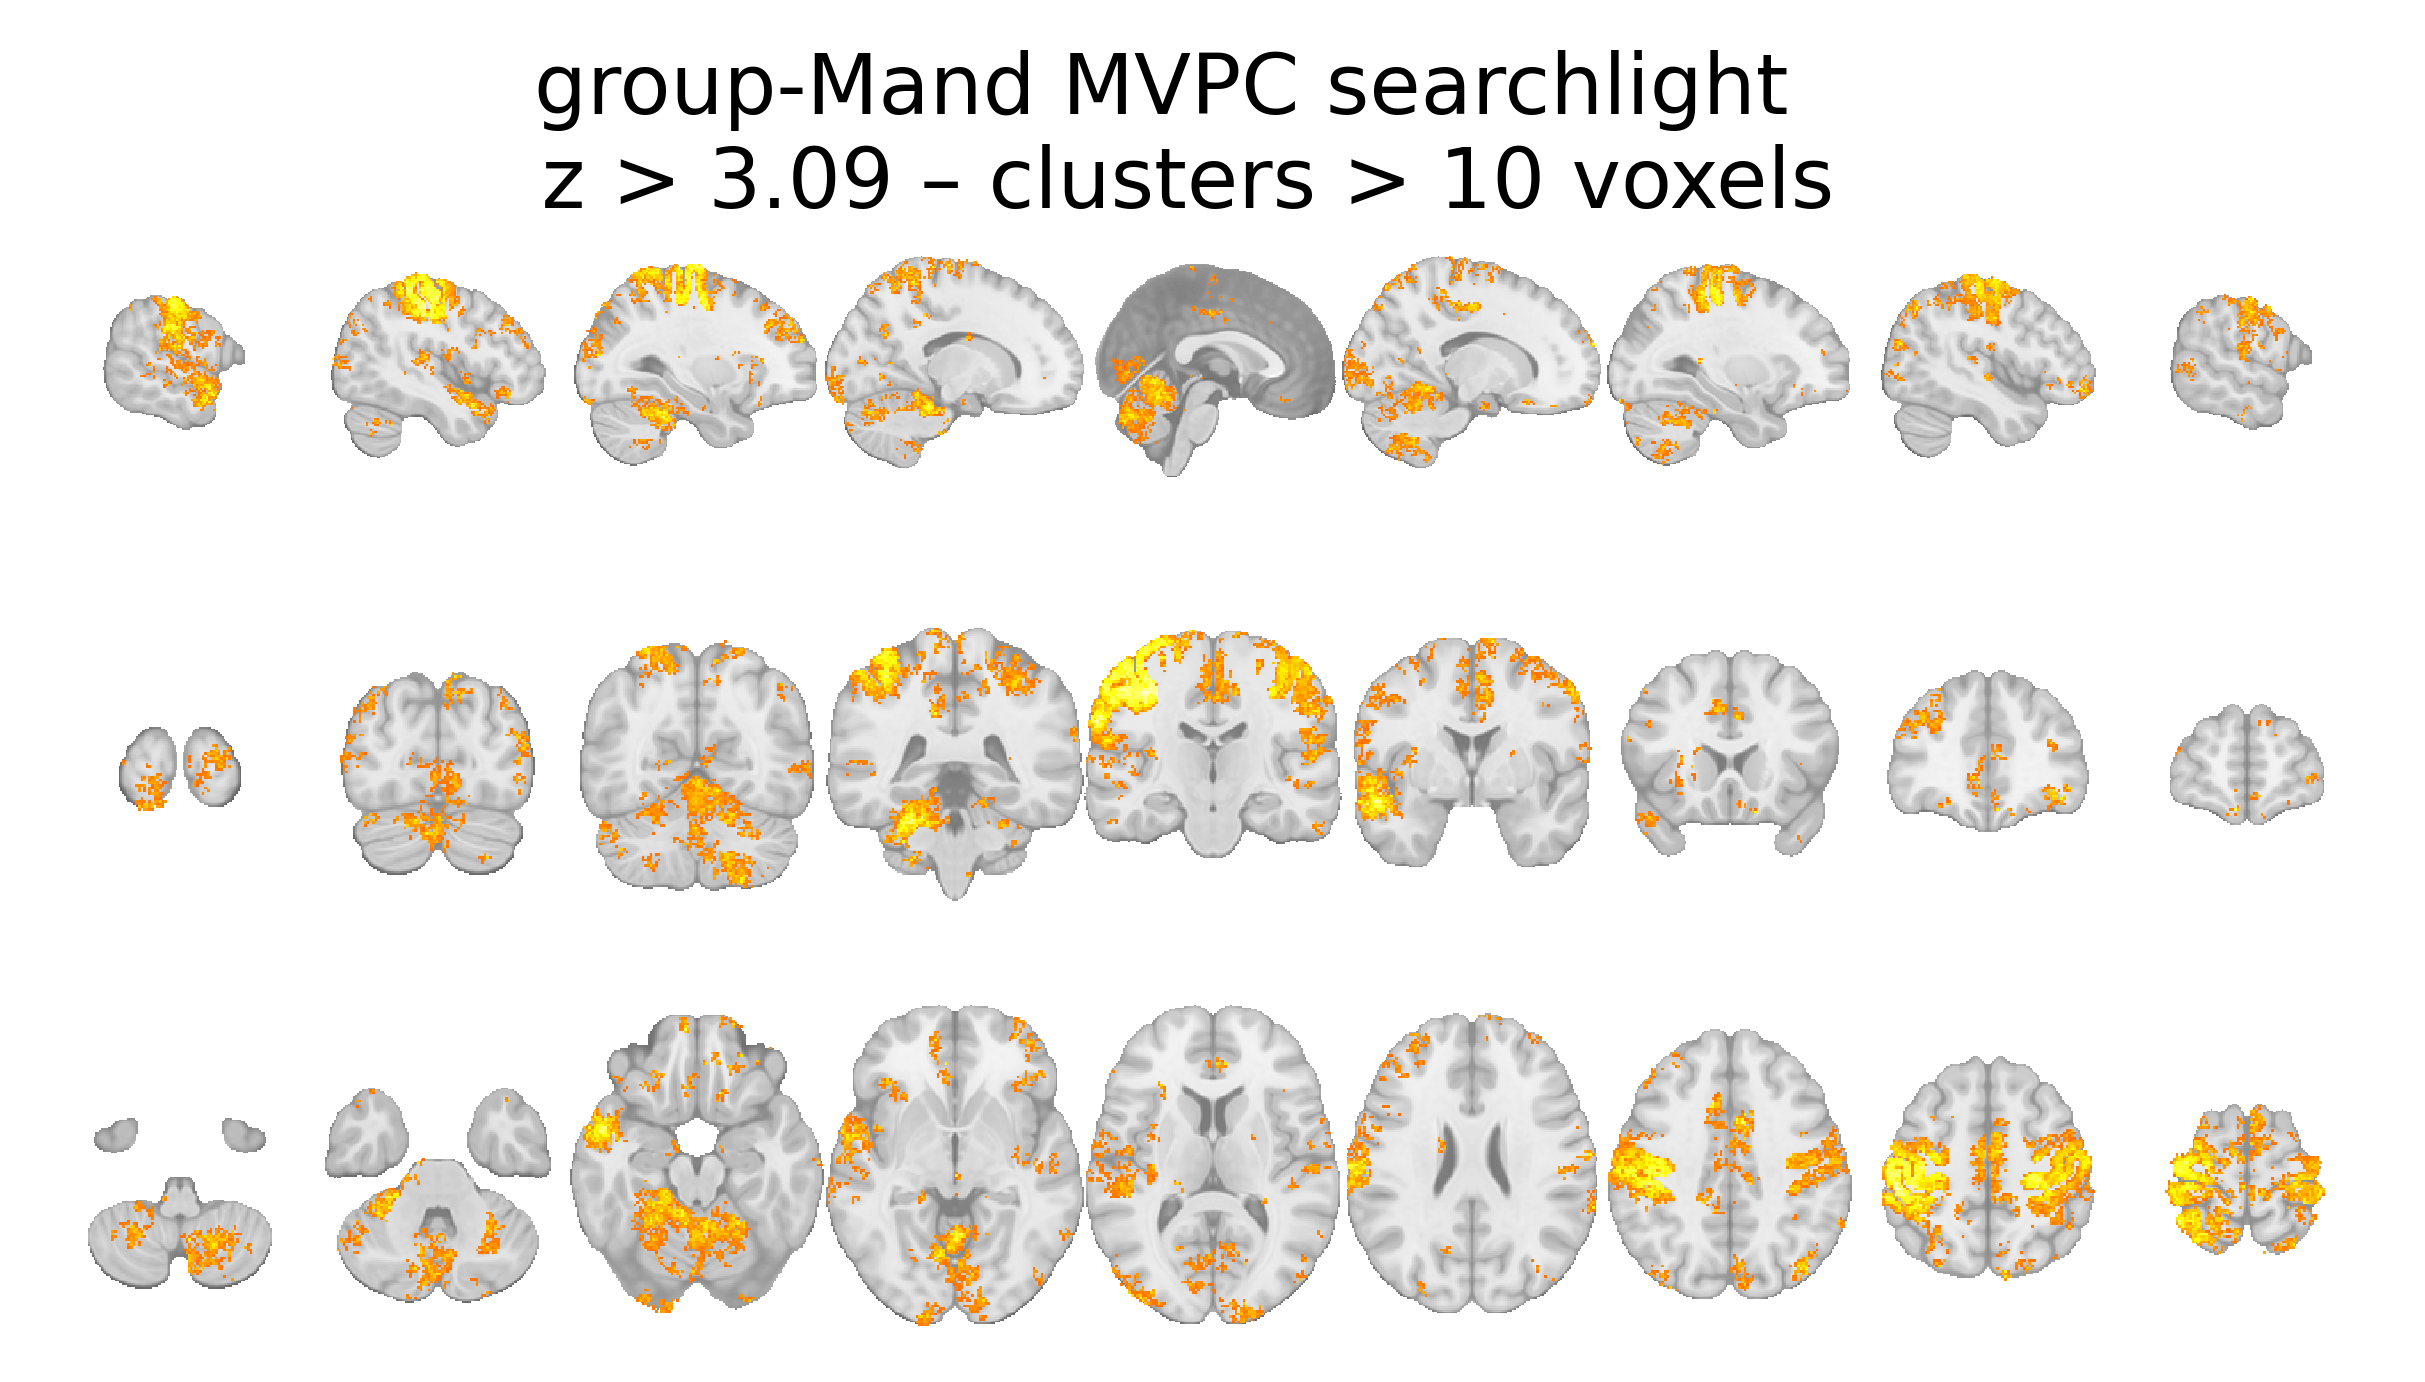

In [122]:
group_label = 'Mand'
threshold = 3.09
cthresh = 10

title='group-%s MVPC searchlight \n z > %.02f – clusters > %d voxels'%(group_label, threshold, cthresh)

#fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
#subfigs = fig.subfigures(nrows=3, ncols=1)
fig, axes = plt.subplots(3, 1, figsize=(6,3), dpi=500)
fig.suptitle(title)

fig_fpath = os.path.join('level-2_mvpc-searchlight', 
                         f'group-{group_label}_mvpc-searchlight_searchmm-{search_radmm}_fwhm-{fwhm}_map-zstat_slice.png')

plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='x',
                       cut_coords=[-60, -45, -30, -15, 0, 15, 30, 45, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[0])
plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='y',
                       cut_coords=[-100, -80, -60, -40, -20, 0, 20, 40, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[1])
plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='z',
                       cut_coords=[-50, -35, -20, -5, 10, 25, 40, 55, 70],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       #figure=fig, 
                       axes=axes[2])

fig.savefig(fig_fpath)
print('file saved to ', fig_fpath)

#### Non-Mandarin-speaking participants group accuracy

In [123]:
group_label = 'NMan'

#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[0,1], output_type='z_score')

In [124]:
from nilearn.image import threshold_img
threshold = 3.09
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=False,
                            )

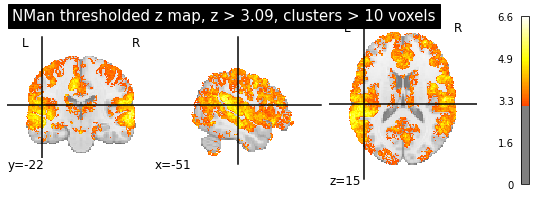

In [125]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



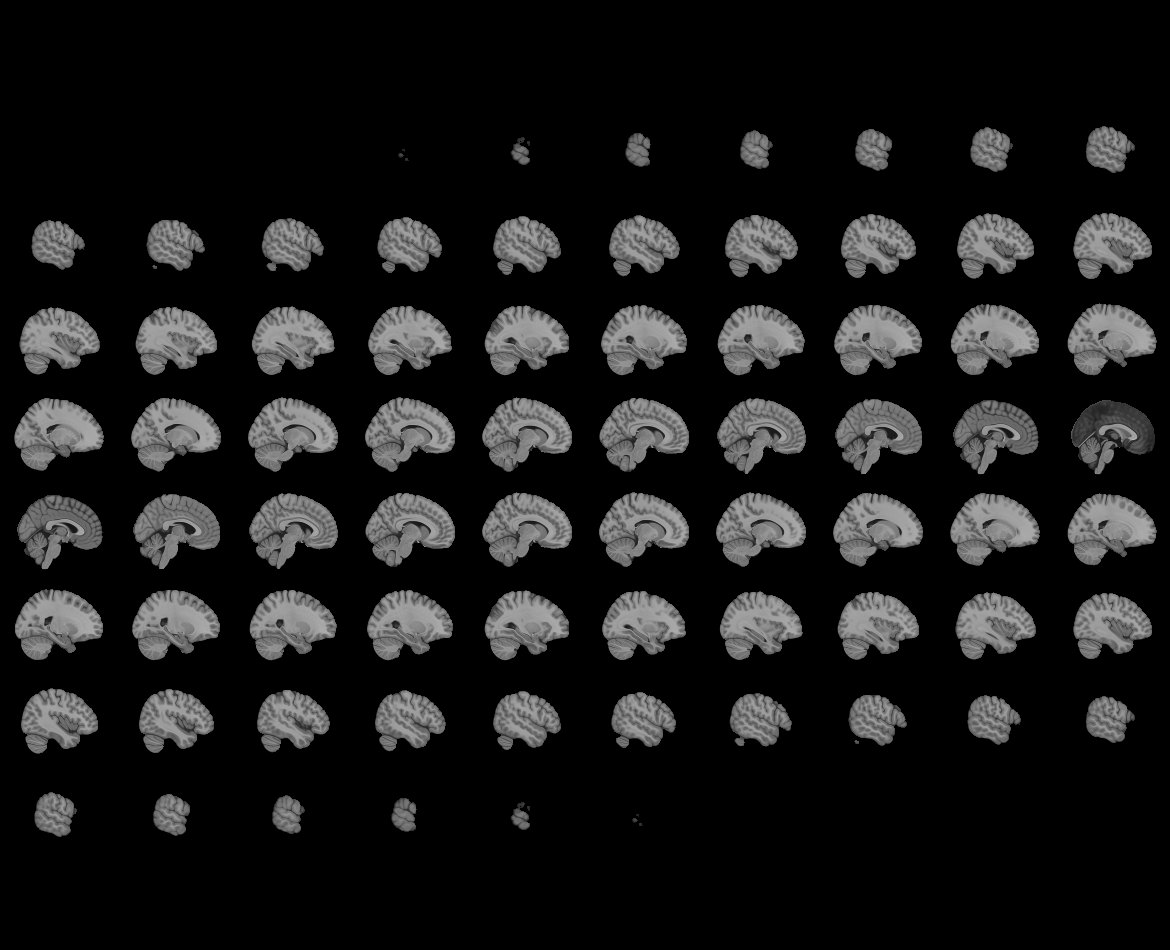
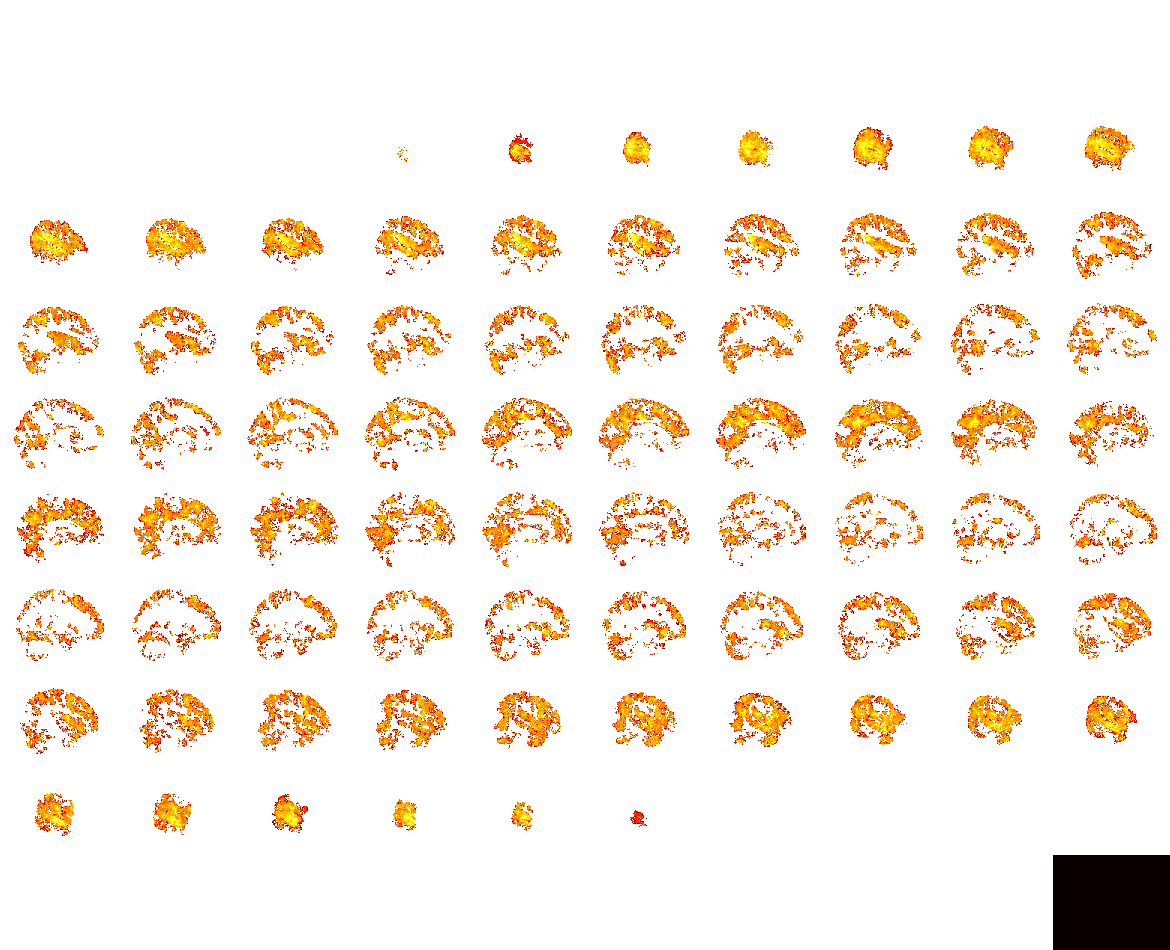

In [126]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  cmap='black_red',
                  symmetric_cmap=False)

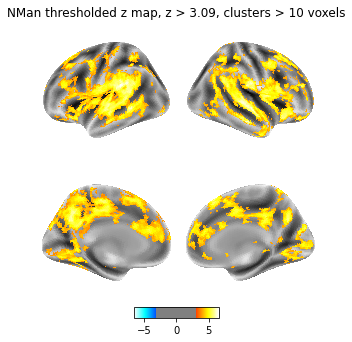

In [127]:
plotting.plot_img_on_surf(thresholded_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          inflate=True,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

file saved to  level-2_mvpc-searchlight/group-NMan_mvpc-searchlight_searchmm-12_fwhm-0.0_map-zstat_slice.png


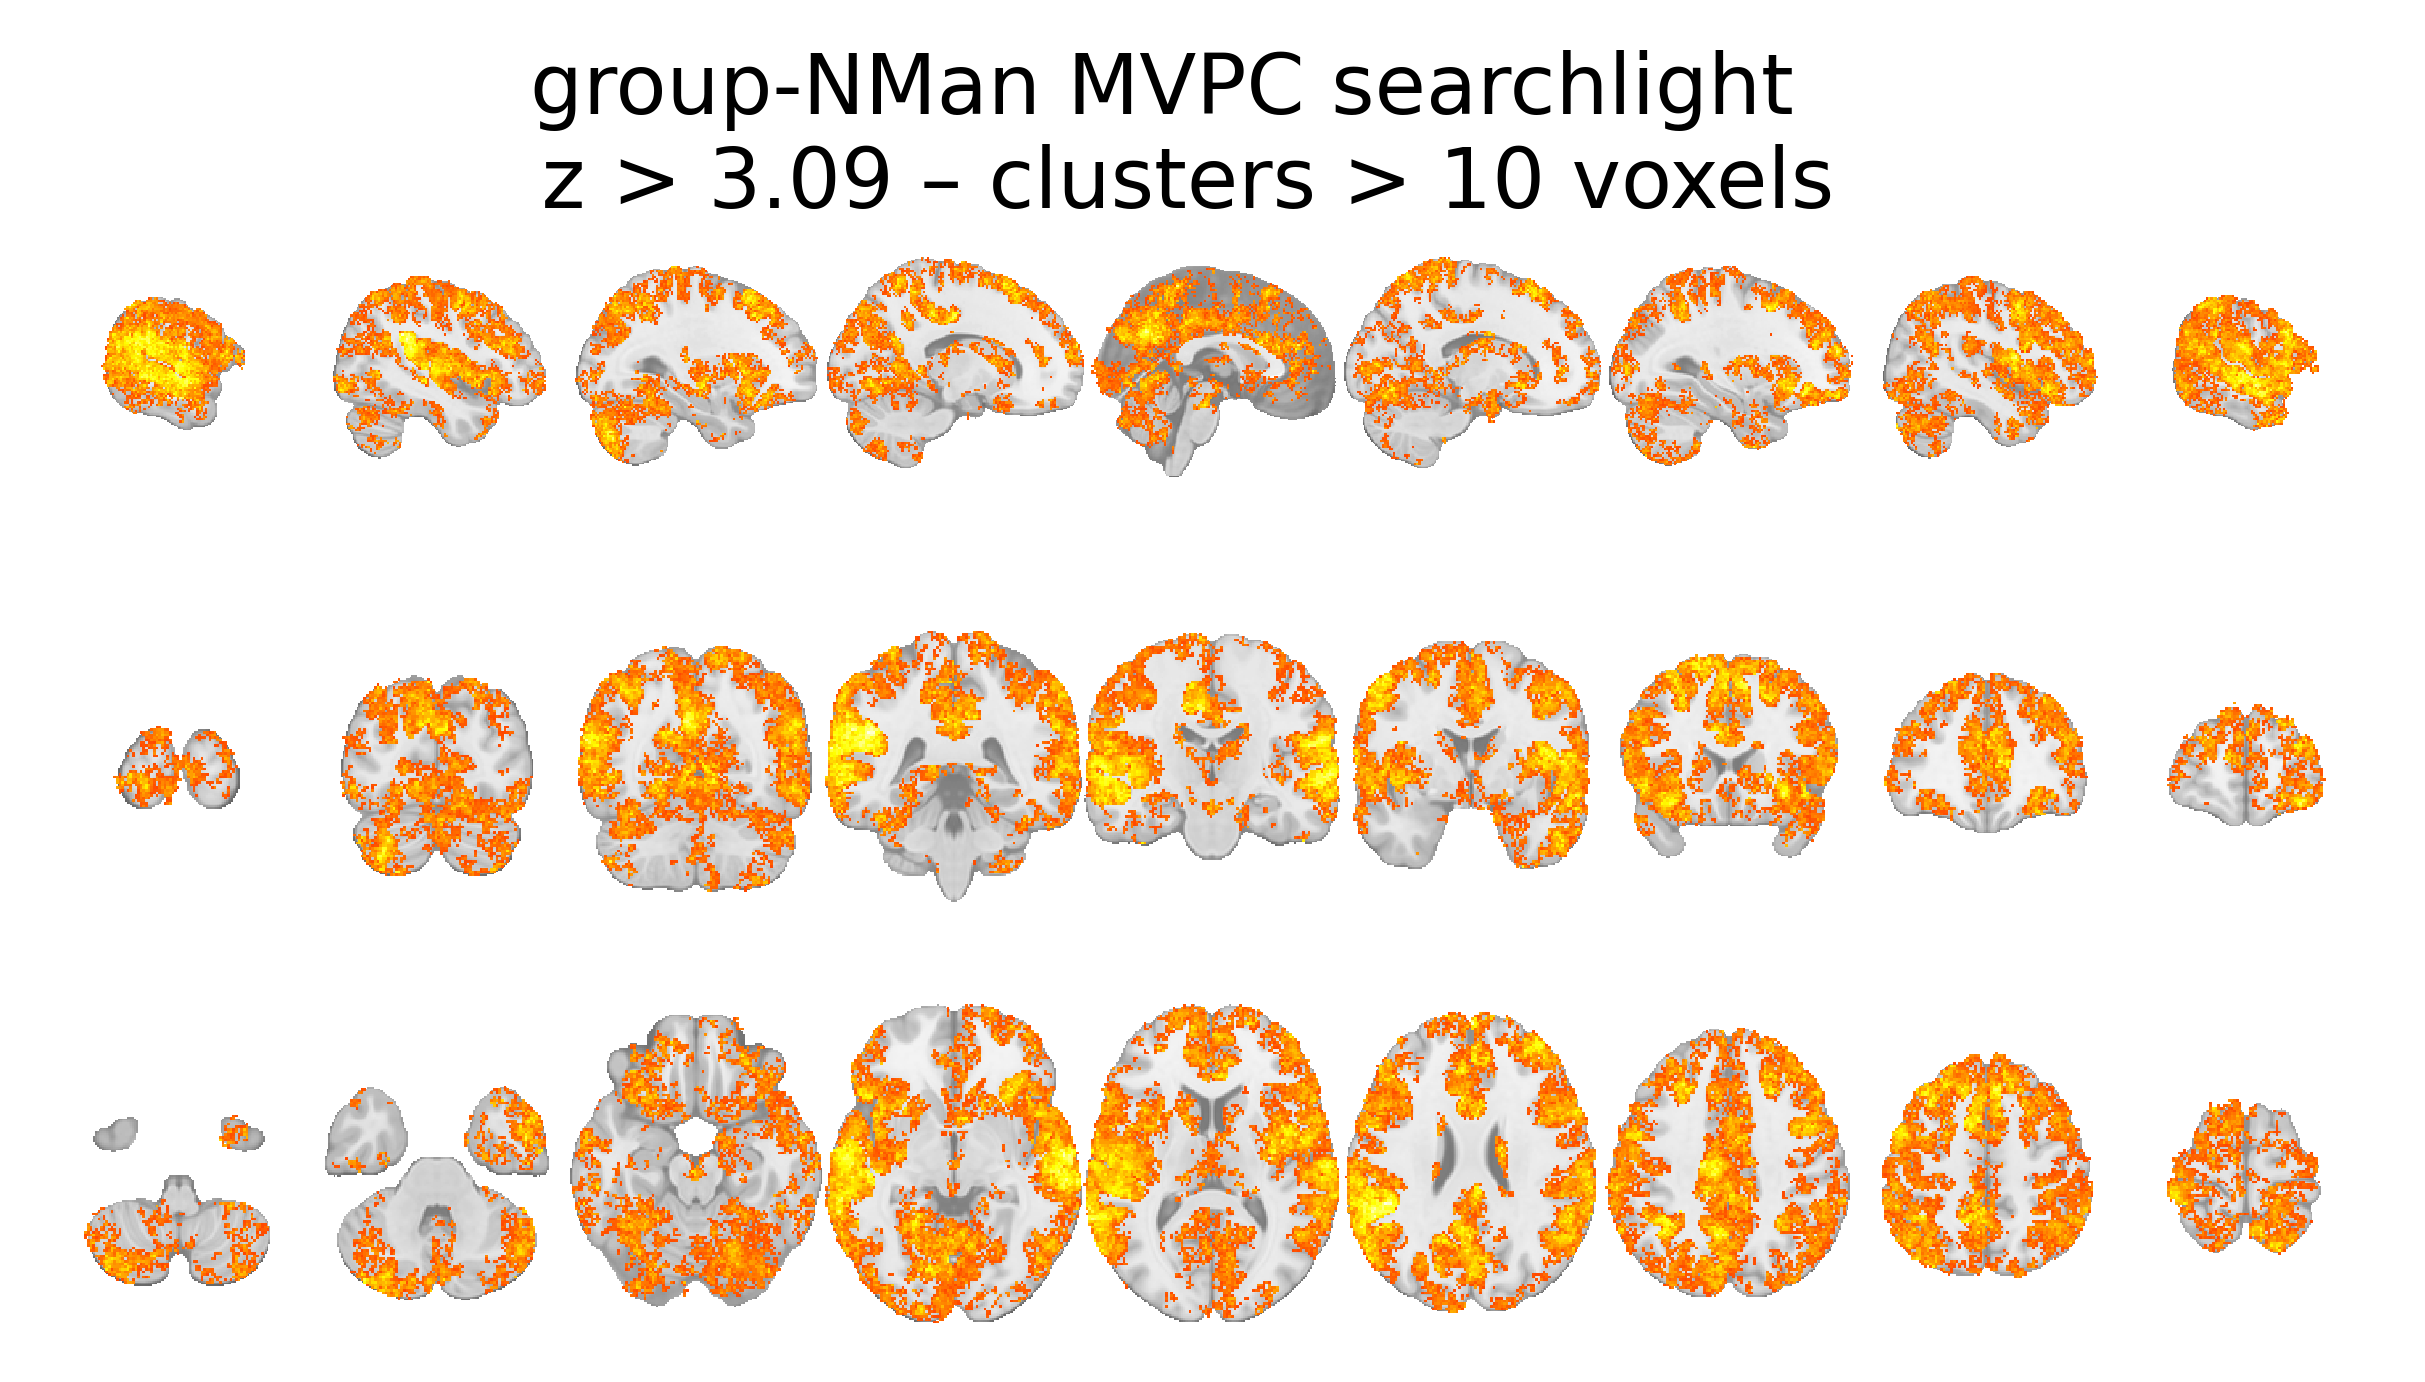

In [128]:
cthresh = 10

title='group-%s MVPC searchlight \n z > %.02f – clusters > %d voxels'%(group_label, threshold, cthresh)

#fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
#subfigs = fig.subfigures(nrows=3, ncols=1)
fig, axes = plt.subplots(3, 1, figsize=(6,3), dpi=500)
fig.suptitle(title)

fig_fpath = os.path.join('level-2_mvpc-searchlight', 
                         f'group-{group_label}_mvpc-searchlight_searchmm-{search_radmm}_fwhm-{fwhm}_map-zstat_slice.png')

plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       threshold=threshold,
                       display_mode='x',
                       cut_coords=[-60, -45, -30, -15, 0, 15, 30, 45, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[0])
plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       threshold=threshold,
                       display_mode='y',
                       cut_coords=[-100, -80, -60, -40, -20, 0, 20, 40, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[1])
plotting.plot_stat_map(thresholded_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       threshold=threshold,
                       display_mode='z',
                       cut_coords=[-50, -35, -20, -5, 10, 25, 40, 55, 70],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       #figure=fig, 
                       axes=axes[2])

fig.savefig(fig_fpath)
print('file saved to ', fig_fpath)

#### Group differences in searchlight accuracy

In [129]:
group_label = 'diff-Mand-gt-NMan'

#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)
z_map_diff = second_level_model.compute_contrast(second_level_contrast=[1, -1,], output_type='z_score')

In [130]:
from nilearn.image import threshold_img
threshold = 2.57
cthresh = 10
thresh_diff_map = threshold_img(
                                z_map_diff,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

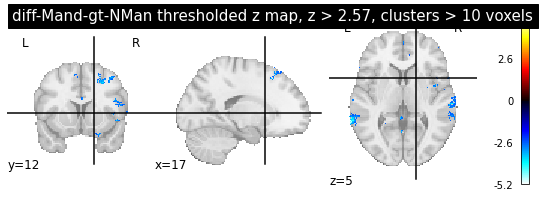

In [131]:
plotting.plot_stat_map(
    thresh_diff_map, cut_coords=[17,12,5], 
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



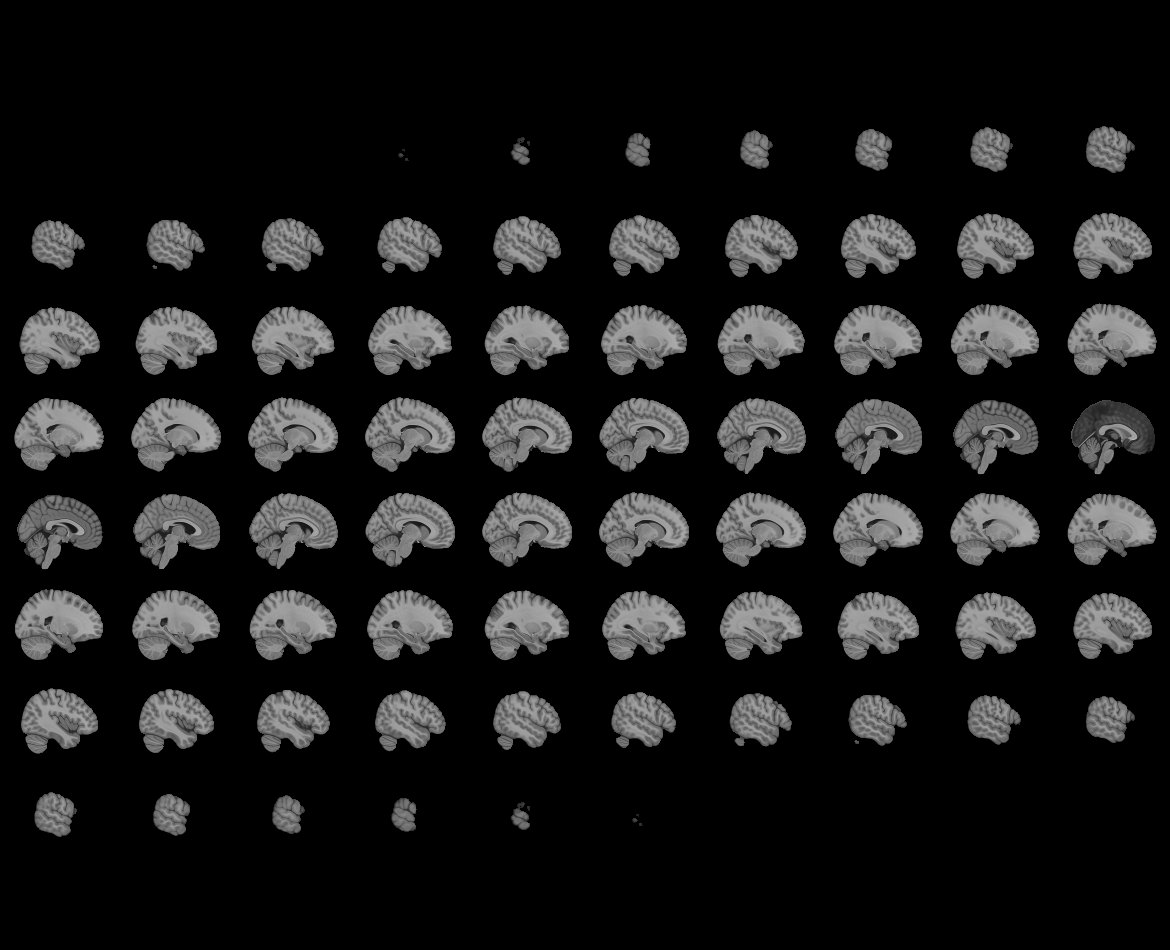
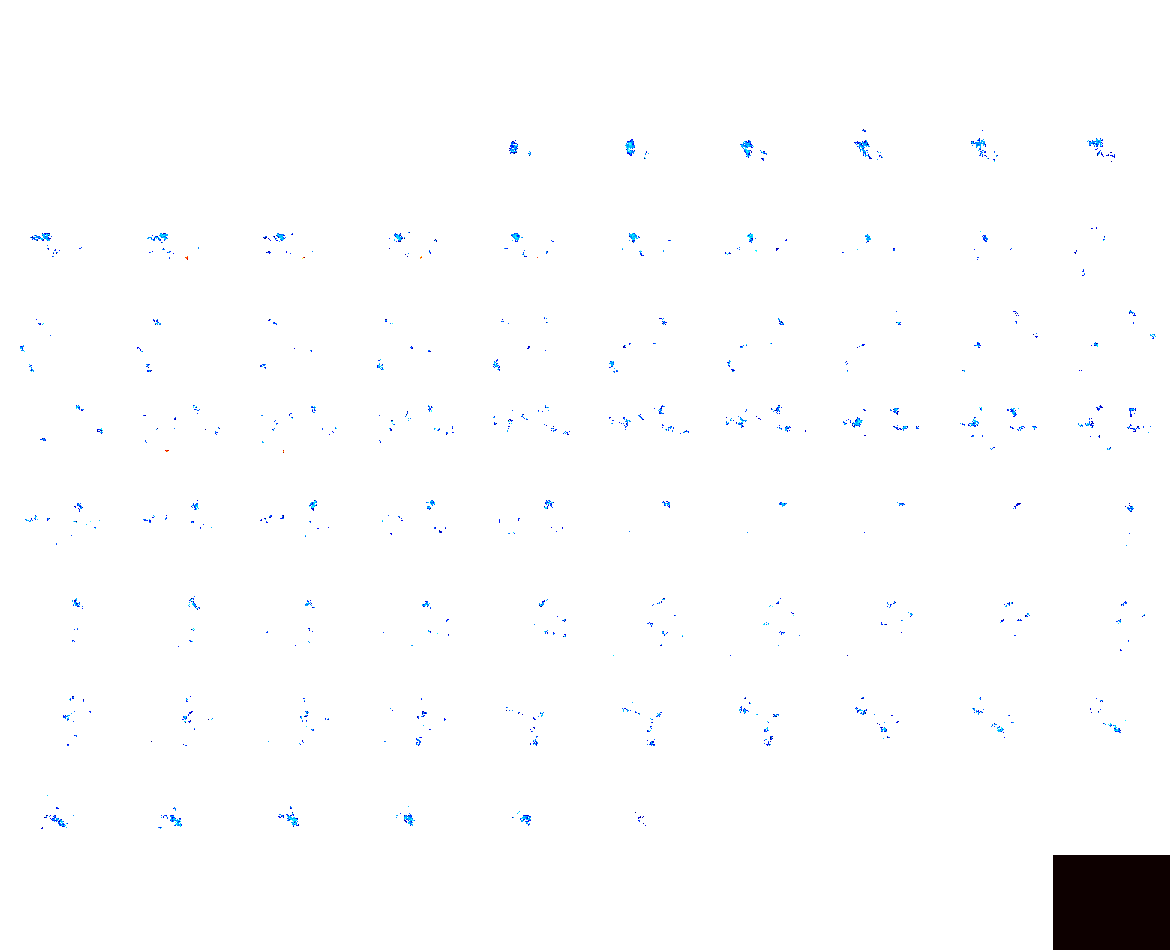

In [132]:
plotting.view_img(thresh_diff_map,
                  threshold=threshold,
                  symmetric_cmap=True)

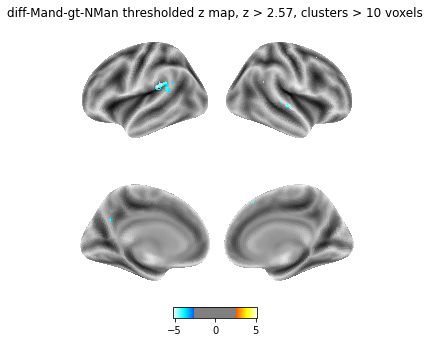

In [133]:
plotting.plot_img_on_surf(thresh_diff_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          inflate=True,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

file saved to  level-2_mvpc-searchlight/group-diff-Mand-gt-NMan_mvpc-searchlight_searchmm-12_fwhm-0.0_map-zstat_slice.png


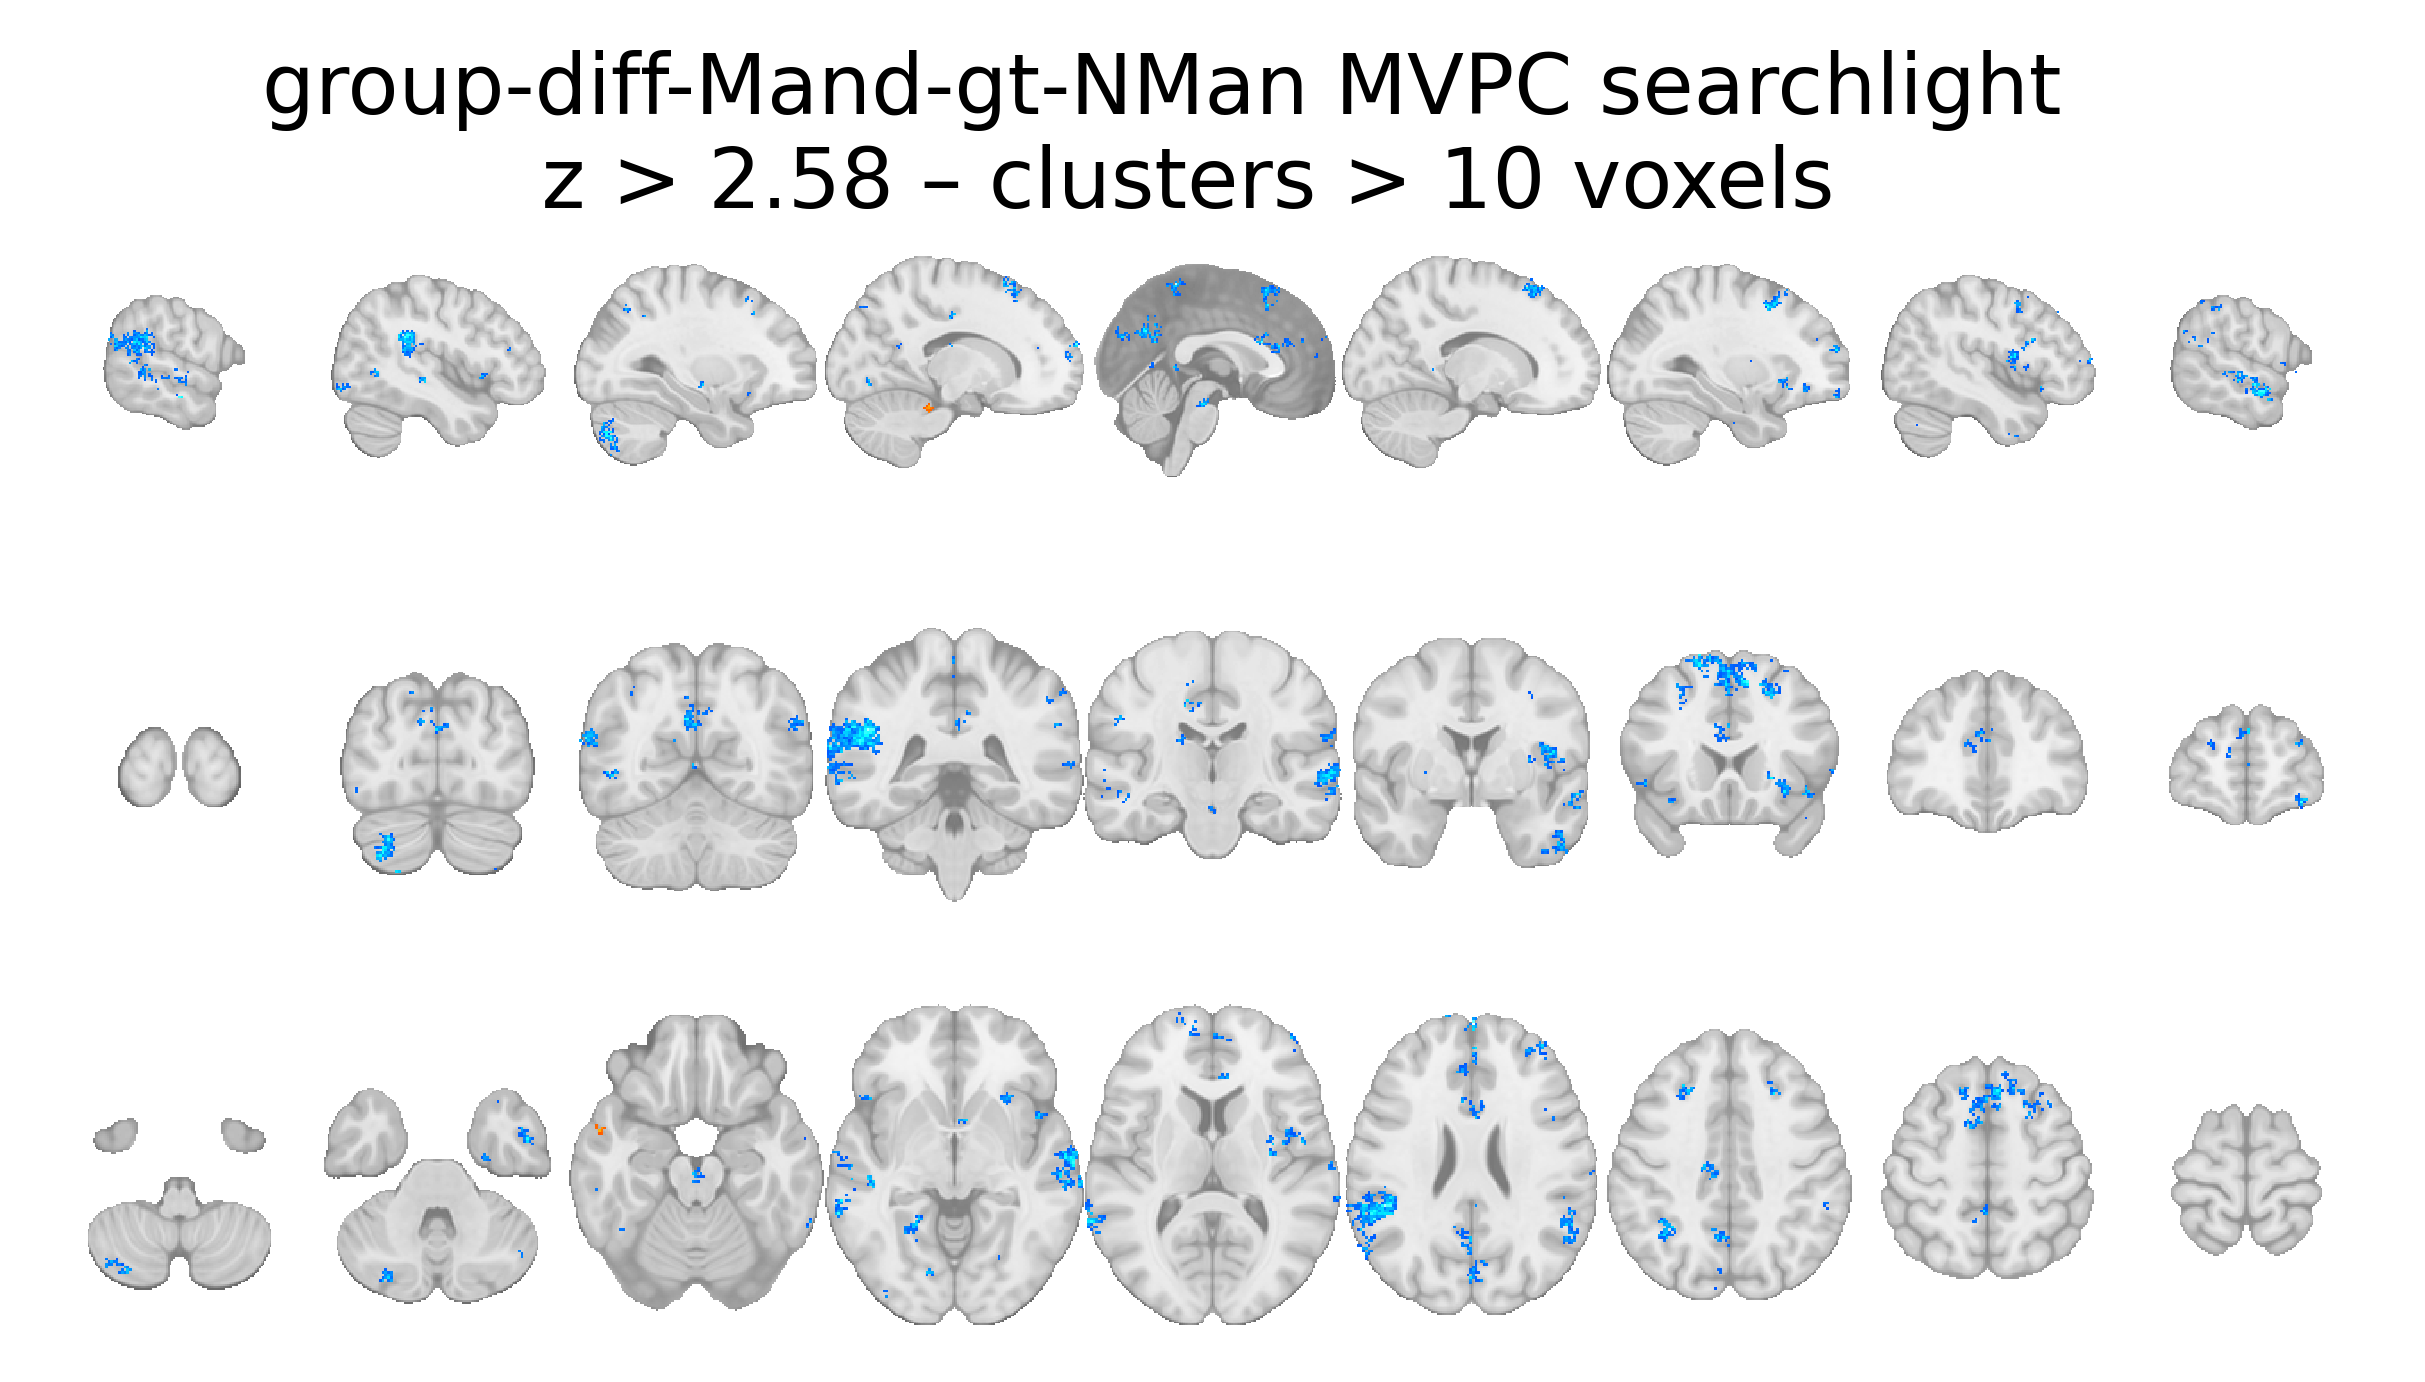

In [134]:
threshold = 2.58
cthresh = 10

title='group-%s MVPC searchlight \n z > %.02f – clusters > %d voxels'%(group_label, threshold, cthresh)

#fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
#subfigs = fig.subfigures(nrows=3, ncols=1)
fig, axes = plt.subplots(3, 1, figsize=(6,3), dpi=500)
fig.suptitle(title)

fig_fpath = os.path.join('level-2_mvpc-searchlight', 
                         f'group-{group_label}_mvpc-searchlight_searchmm-{search_radmm}_fwhm-{fwhm}_map-zstat_slice.png')

plotting.plot_stat_map(thresh_diff_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='x',
                       cut_coords=[-60, -45, -30, -15, 0, 15, 30, 45, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[0])
plotting.plot_stat_map(thresh_diff_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='y',
                       cut_coords=[-100, -80, -60, -40, -20, 0, 20, 40, 60],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       figure=fig, 
                       axes=axes[1])
plotting.plot_stat_map(thresh_diff_map, 
                       bg_img=mni152_template, 
                       black_bg=False,
                       display_mode='z',
                       cut_coords=[-50, -35, -20, -5, 10, 25, 40, 55, 70],
                       colorbar=False,
                       annotate=False,
                       #title=title,
                       #figure=fig, 
                       axes=axes[2])

fig.savefig(fig_fpath)
print('file saved to ', fig_fpath)

## test: group overlap

In [10]:
search_label

'searchlight_radius-9'

In [22]:
thr_acc = 0.45

fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm)

for group_label in ['mand']: # ['mand', 'nman']
    group_mask_sl_thr = []
    if group_label == 'mand':
        sub_loop_list = sub_list_mand
    elif group_label == 'nman':
        sub_loop_list = sub_list_nman

    for mask_label in ['gm_cond-tone']:
        print(mask_label)
        mask_sl_thr_array = []

        for sx, sub_id in enumerate(sub_loop_list):
            sub_mask_sl_fpath = os.path.join(nilearn_dir, '%s_space-%s'%(sub_id, space_label), search_label, 
                                             '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
            sub_sl_img = nib.load(sub_mask_sl_fpath)

            sub_sl_data = sub_sl_img.get_fdata()

            # threshold/binarize
            sub_sl_thr = np.where(sub_sl_data > thr_acc, 1, 0)
            mask_sl_thr_array.append(sub_sl_thr)

        # create a group count image
        group_mask_sl_thr = np.sum(mask_sl_thr_array, axis=0)
        group_sl_img = nib.Nifti1Image(group_mask_sl_thr, affine=sub_sl_img.affine)
        group_sl_dir = os.path.join(nilearn_dir, 'searchlight_group')
        if not os.path.exists(group_sl_dir):
                os.makedirs(group_sl_dir)
        group_sl_fpath = os.path.join(group_sl_dir, 'group-{}_mask-{}_{}_thr-{}.nii.gz'.format(group_label, mask_label, search_label, thr_acc))
        #nib.save(group_sl_img, group_sl_fpath)
        #print('saved group image to ', group_sl_fpath)

gm_cond-tone


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



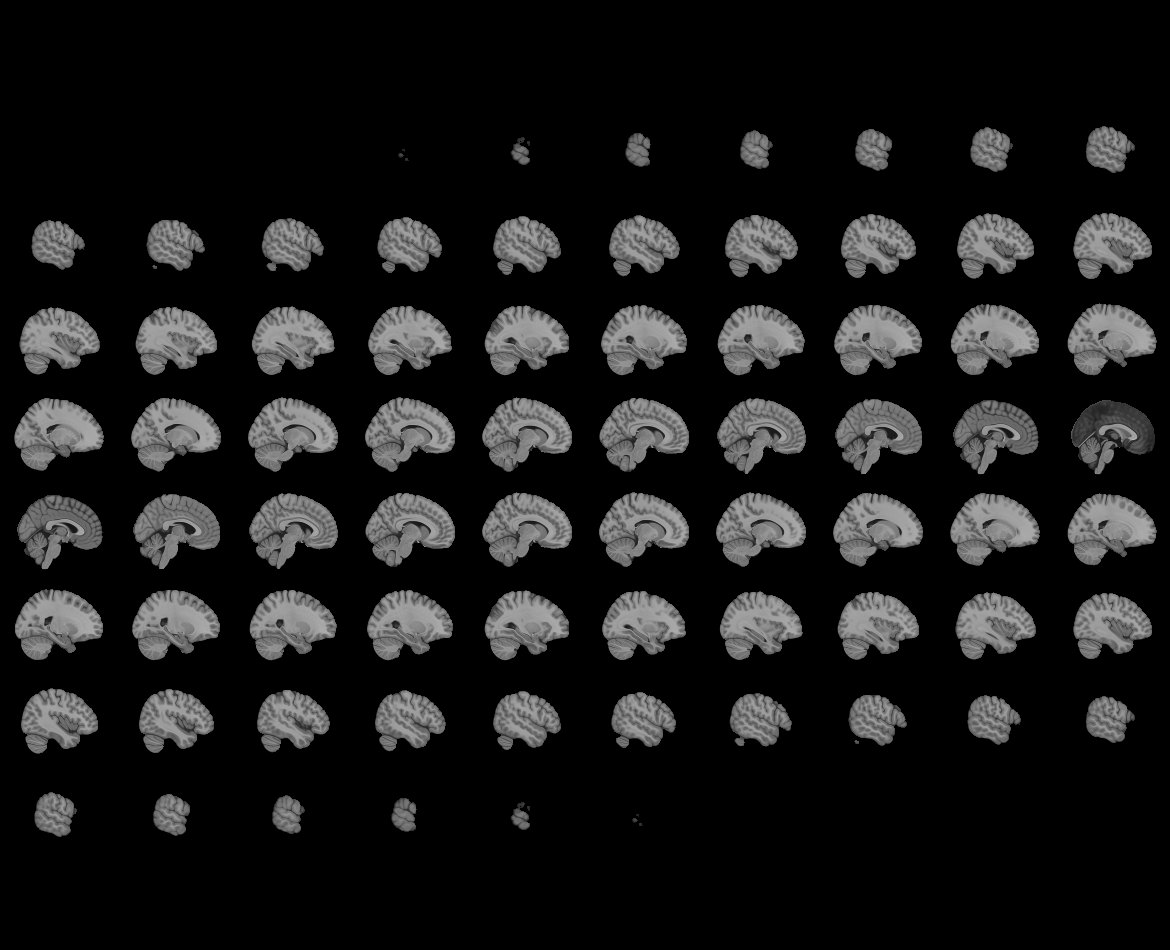
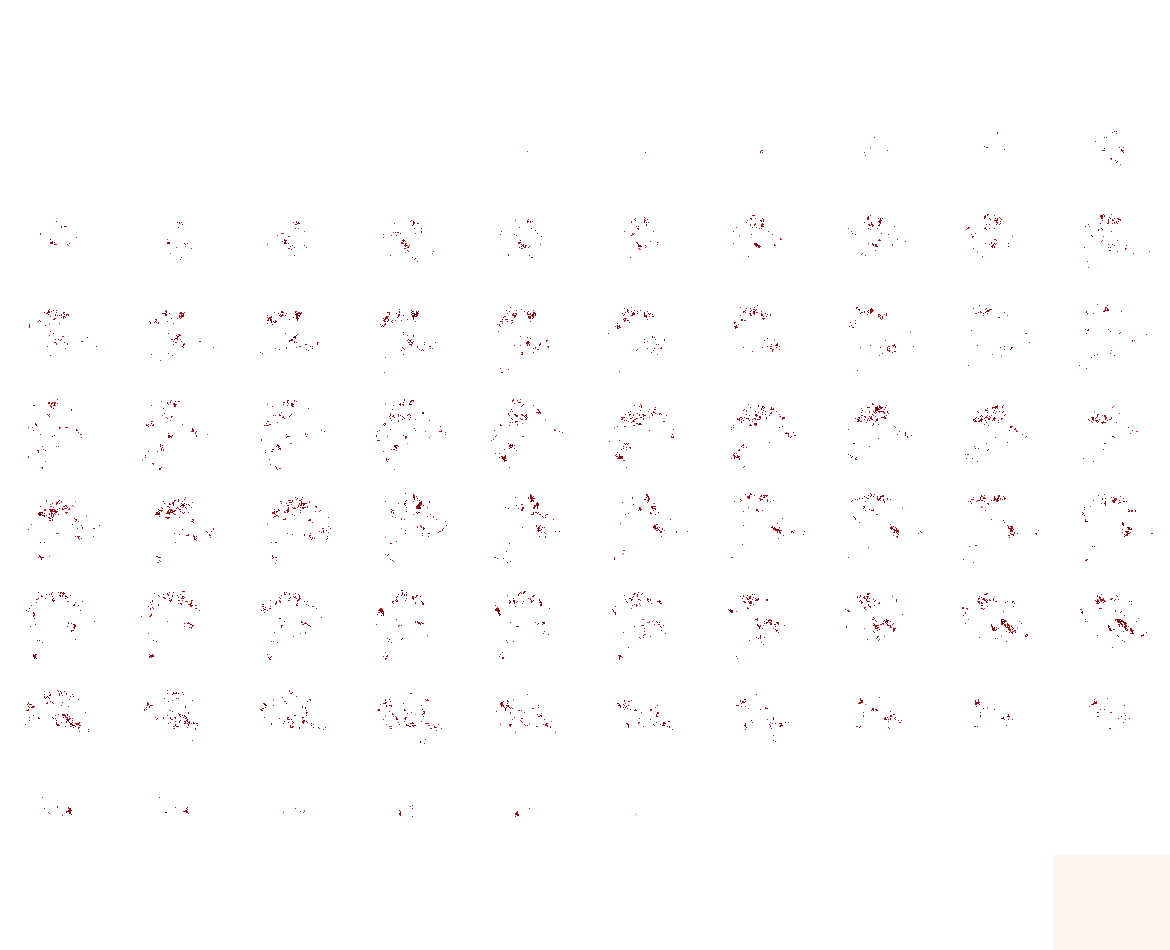

In [26]:
plotting.view_img(group_sl_img,
                  symmetric_cmap=False,
                  cmap='Reds',
                  threshold=8)

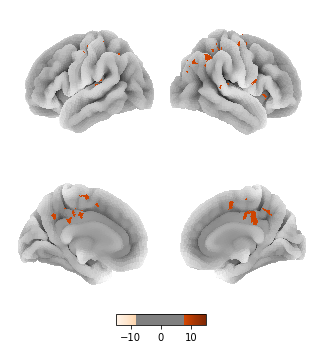

In [27]:
plotting.plot_img_on_surf(group_sl_img,
                          surf_mesh='fsaverage5',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=8,
                          vmax=15,
                          colorbar=True,
                          cmap='Oranges',
                         )
plotting.show()

In [31]:
mni152_template = datasets.load_mni152_template(resolution=1)

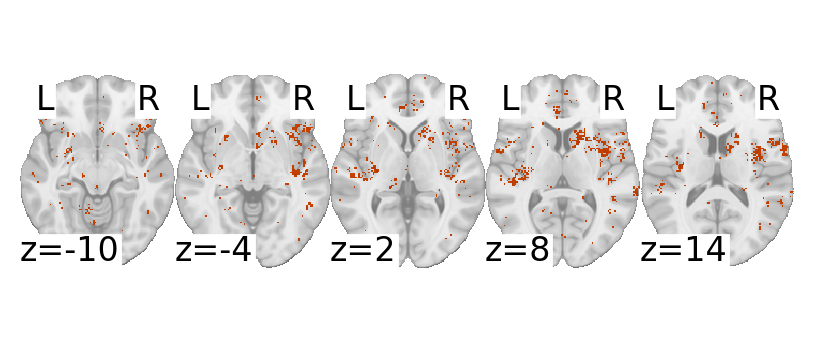

In [32]:
fig1, ax1 = plt.subplots(figsize=(5,2), dpi=200)
plotting.plot_stat_map(group_sl_img,
                       bg_img=mni152_template,
                       threshold=8,
                       vmax=15,
                       cmap='Oranges',
                       cut_coords=[-10, -4, 2, 8, 14],
                       display_mode='z',
                       colorbar=False, 
                       draw_cross=False, 
                       black_bg=False,
                       axes=ax1)

#### Non-Mandarin-speaking participants

In [27]:
thr_acc = 0.5

fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm)

for group_label in ['nman']:
    group_mask_sl_thr = []
    if group_label == 'mand':
        sub_loop_list = sub_list_mand
    elif group_label == 'nman':
        sub_loop_list = sub_list_nman

    for mask_label in ['gm_cond-tone']:
        print(mask_label)
        mask_sl_thr_array = []

        for sx, sub_id in enumerate(sub_loop_list):
            sub_mask_sl_fpath = os.path.join(nilearn_dir, '%s_space-%s'%(sub_id, space_label), search_label, 
                                             '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
            sub_sl_img = nib.load(sub_mask_sl_fpath)

            sub_sl_data = sub_sl_img.get_fdata()

            # threshold/binarize
            sub_sl_thr = np.where(sub_sl_data > thr_acc, 1, 0)
            mask_sl_thr_array.append(sub_sl_thr)

        # create a group count image
        group_mask_sl_thr = np.sum(mask_sl_thr_array, axis=0)
        group_sl_img = nib.Nifti1Image(group_mask_sl_thr, affine=sub_sl_img.affine)
        group_sl_dir = os.path.join(nilearn_dir, 'searchlight_group')
        if not os.path.exists(group_sl_dir):
                os.makedirs(group_sl_dir)
        group_sl_fpath = os.path.join(group_sl_dir, 'group-{}_mask-{}_{}_thr-{}.nii.gz'.format(group_label, mask_label, search_label, thr_acc))
        nib.save(group_sl_img, group_sl_fpath)
        print('saved group image to ', group_sl_fpath)

gm_cond-tone
saved group image to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/group-nman_mask-gm_cond-tone_searchlight_radius-6_thr-0.5.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



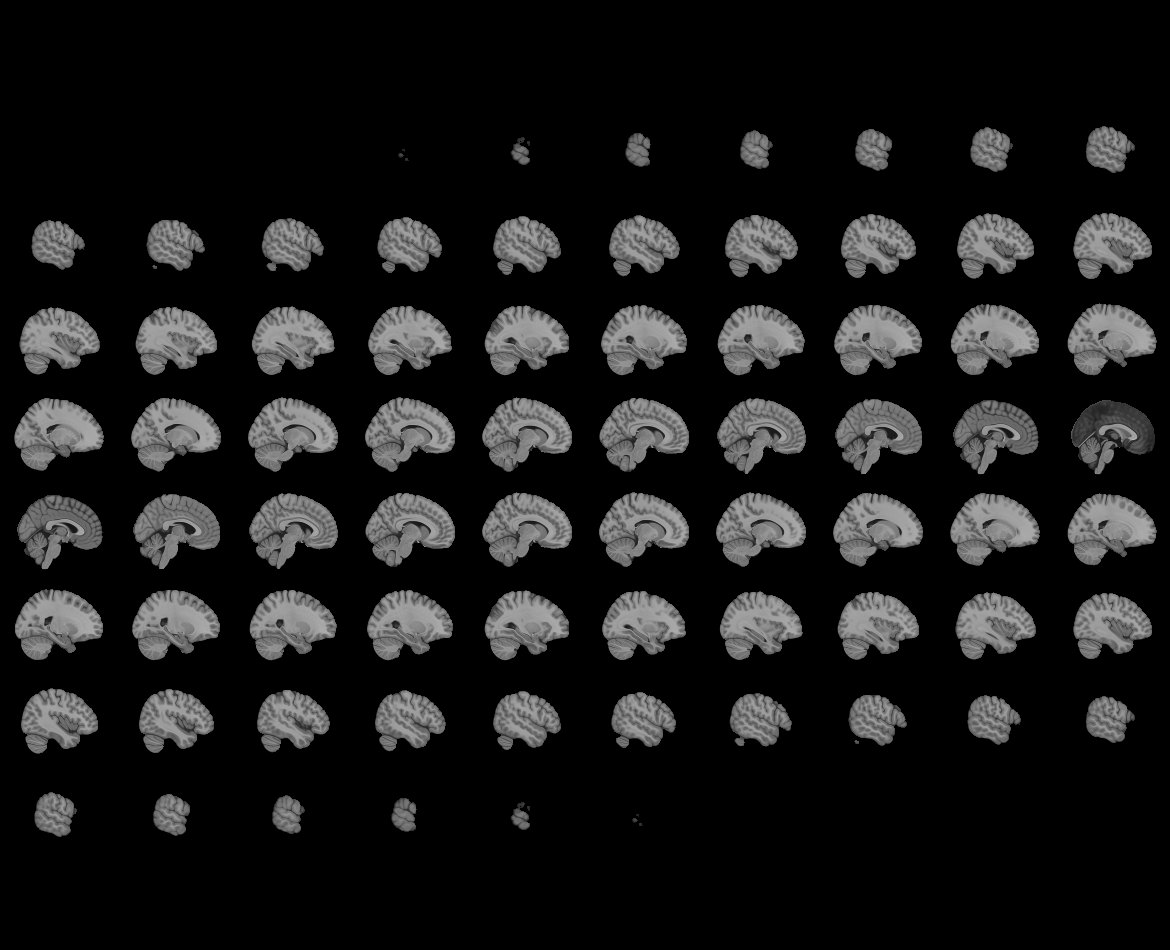
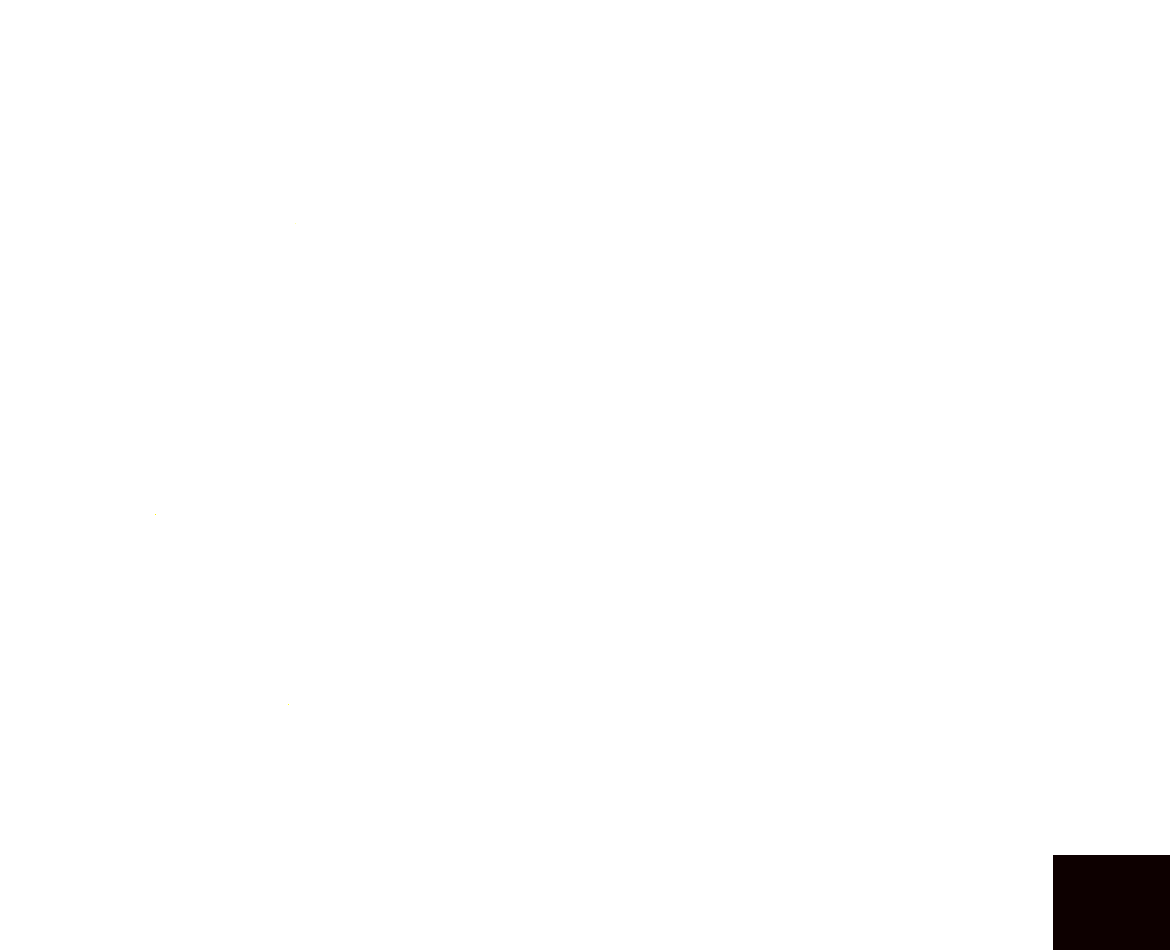

In [28]:
plotting.view_img(group_sl_img,
                  threshold=2)

#### NOT WORKING – plotting from saved group files. currently plotting means or something, not overlaps

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



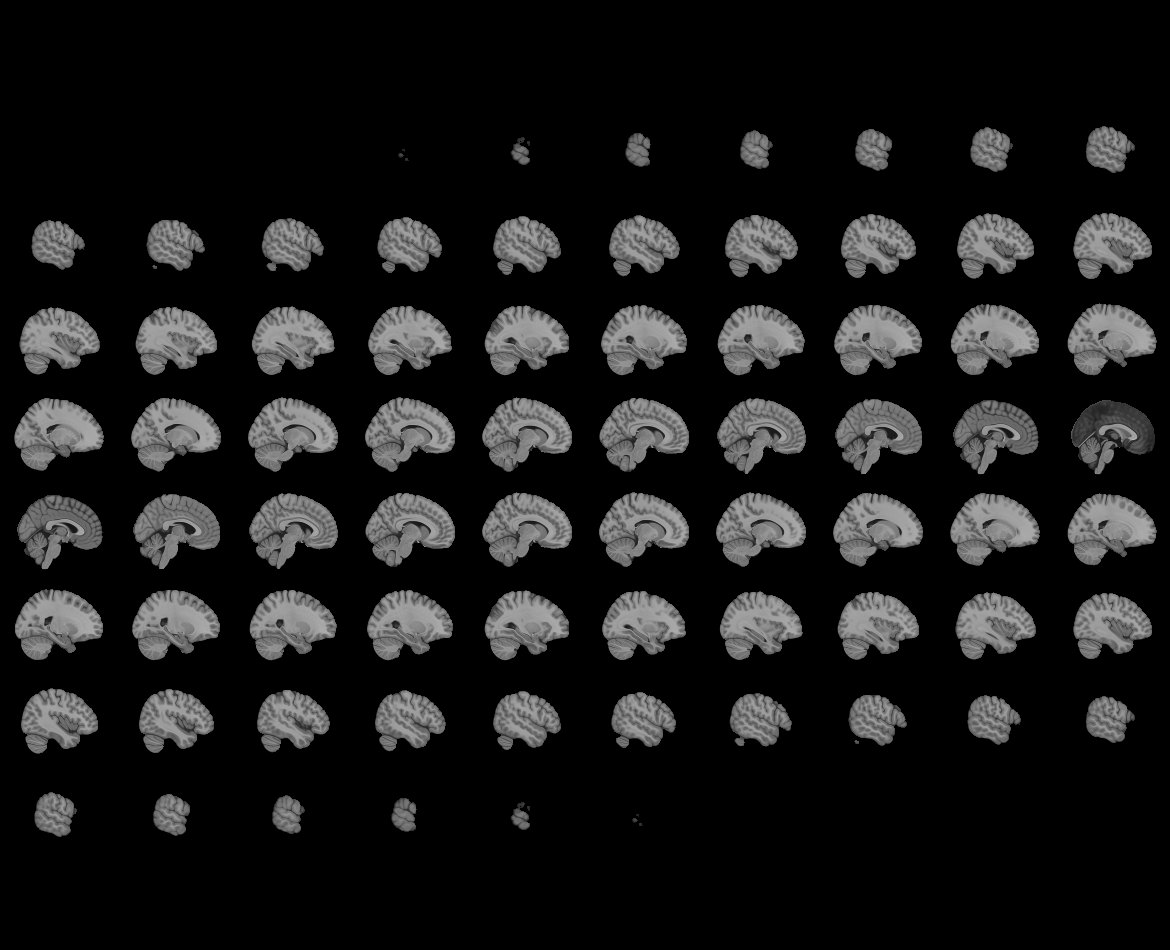
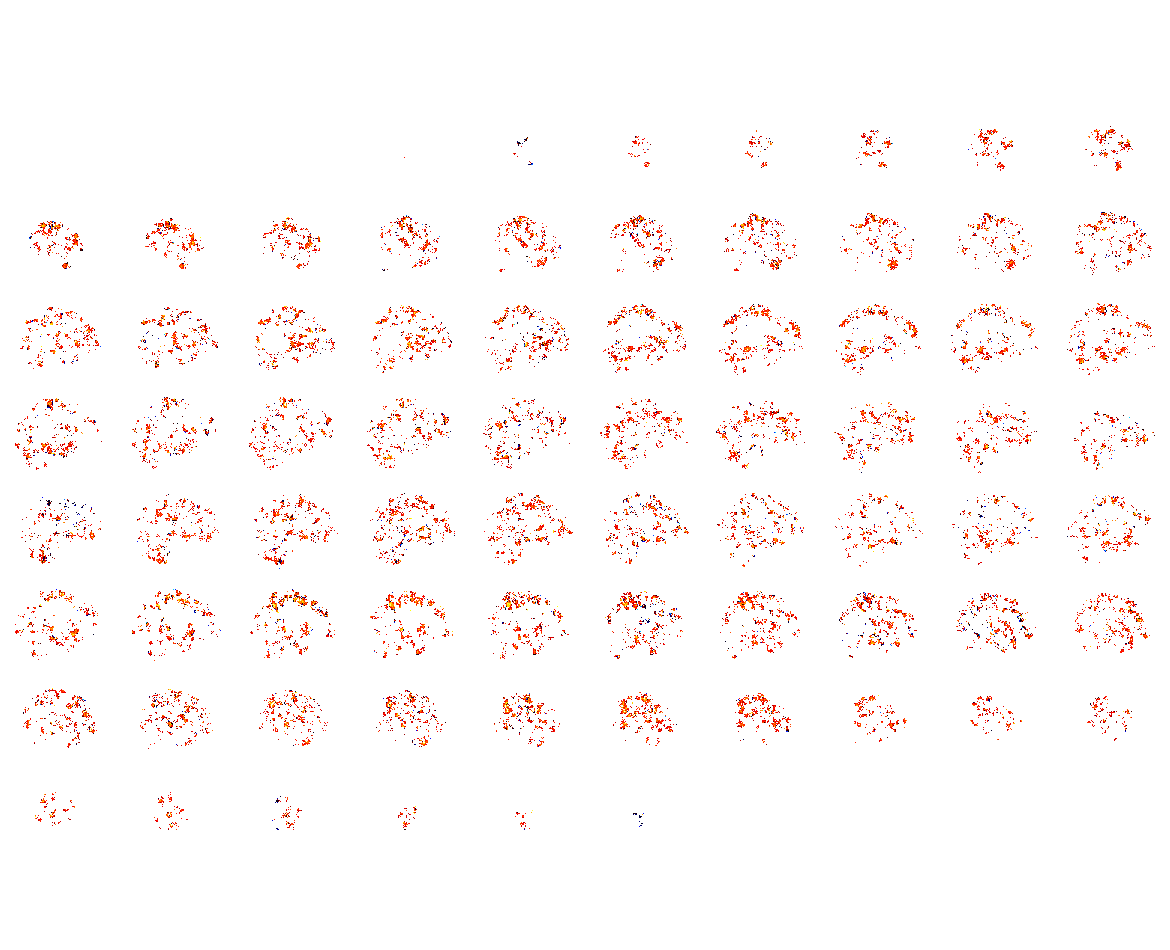

In [29]:
group_img_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/',
                               'derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/',
                               'group-mand_mask-gm_cond-tone_{}_thr-0.5.nii.gz'.format(search_label))
plotting.view_img(img_fpath,
                  threshold=0.5,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title='Mandarin')

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



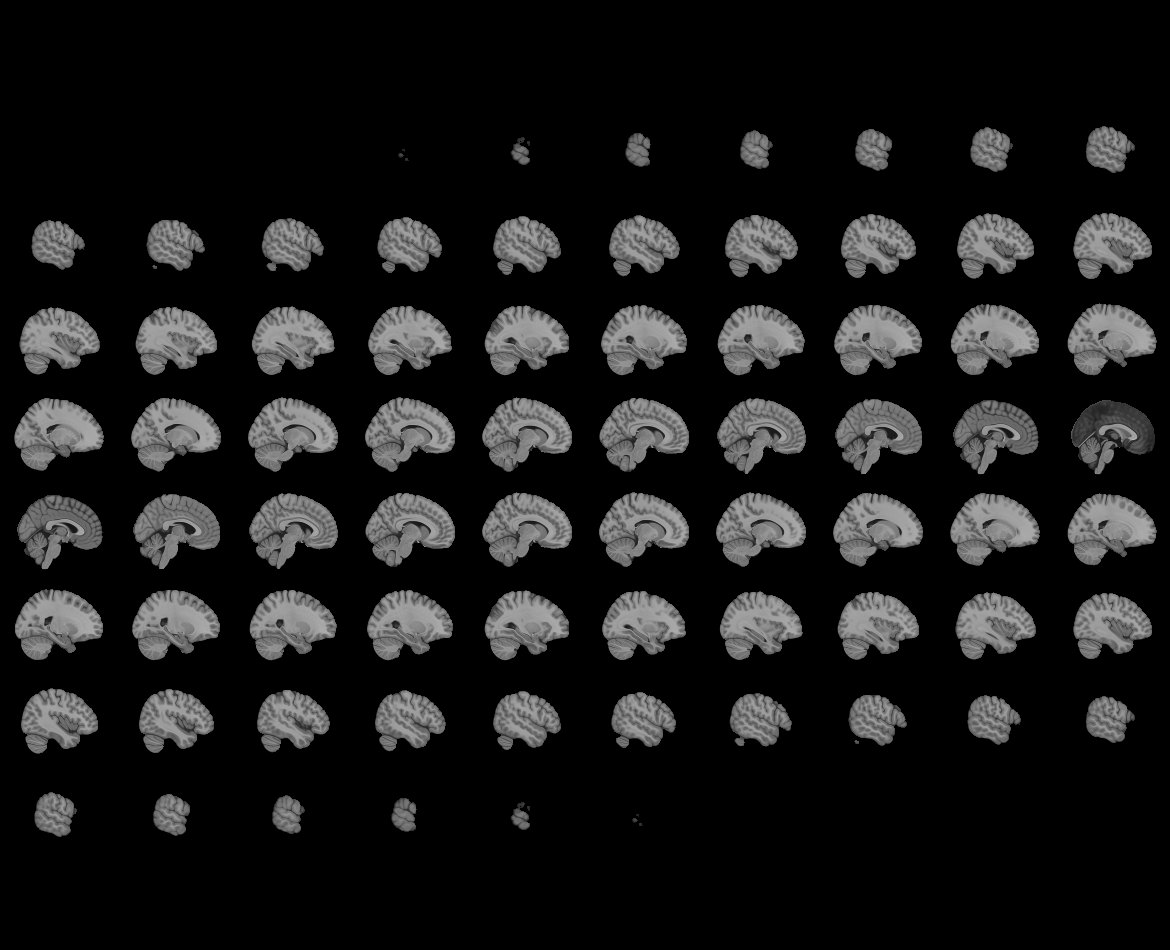
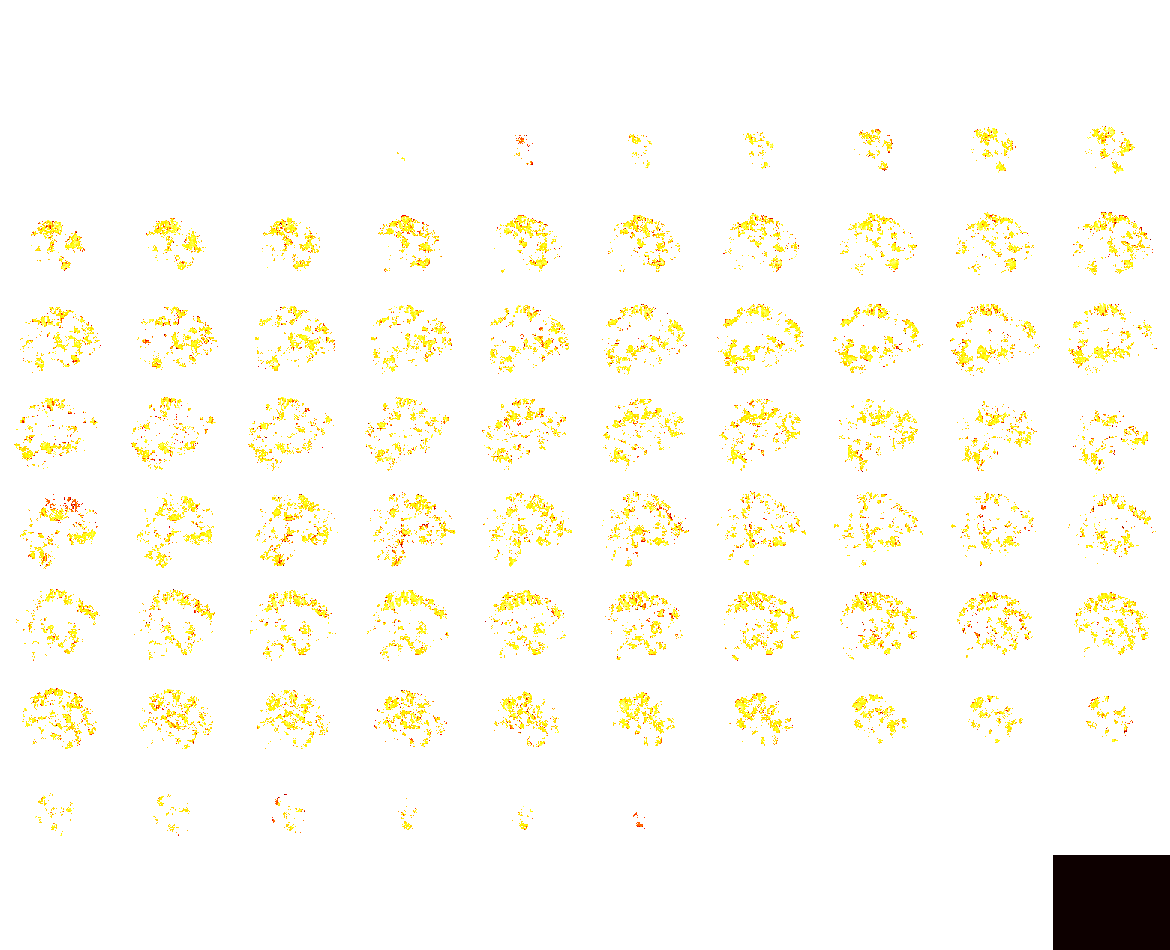

In [125]:
group_img_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/',
                               'derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/',
                               'group-nman_mask-gm_cond-tone_searchlight_radius-9_thr-0.5.nii.gz')
plotting.view_img(img_fpath,
                  threshold=0.5,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title='non-Mandarin')

### test: parametric t-tests

In [39]:
smoothed_l1_fnames_groupdiff = smooth_img(l1_fnames_groupdiff, 3)

In [42]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

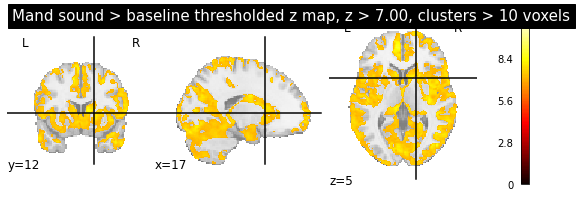

In [43]:
from nilearn.image import threshold_img
threshold = 7 # 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=False,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

## WIP: comparison vs. permuted values

Per [Stelzer et al. (2013)](https://doi.org/10.1016/j.neuroimage.2012.09.063):
> On the single subject level, we employed permutation tests. It is important to highlight that the permutation tests in our method do not serve as a direct means to infer statistical significance on a single subject level, rather they should be regarded as an intermediate module for subsequent group recombination and inference methods (see Fig. 1 for an overview). The reasoning behind permutation tests on a single subject level is to assess chance distributions and chance accuracy maps (Chen et al., 2011, Golland and Fischl, 2003). For this, we created a random permutation of the observation order and applied it to the data set (see Fig. 2 for an overview of the permutation scheme).

Participant-level steps: 
1) Get searchlight accuracies
2) Permute labels and run searchlight (100 times)


In [ ]:
# load participant-level permuted chance maps (computed outside this notebook)
chance_maps_dict = {}
for sx, sub_id in enumerate(sub_list):
    permutation_dir = []
    sub_chance_maps = sorted(glob(permutation_dir))
    chance_maps_dict[sub_id, sub_chance_maps]

**problem**: 

## Permutation tests

In [43]:
from nilearn.glm.second_level import non_parametric_inference

### Mandarin-speaking group:

In [44]:
-np.log10(1 / 1000)

3.0

In [47]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(l1_fnames_groupdiff, # smoothed_l1_fnames_groupdiff, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[1,0],
                             n_perm=2000,
                             n_jobs=1)

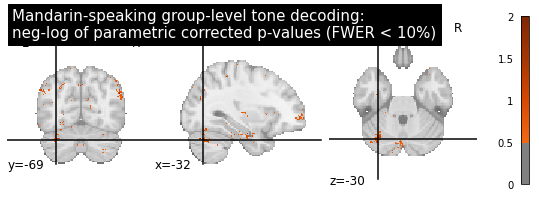

In [48]:
threshold = 0.5 #1.0
title = ('Mandarin-speaking group-level tone decoding: \n'
         'neg-log of parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, 
                       colorbar=True, 
                       threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



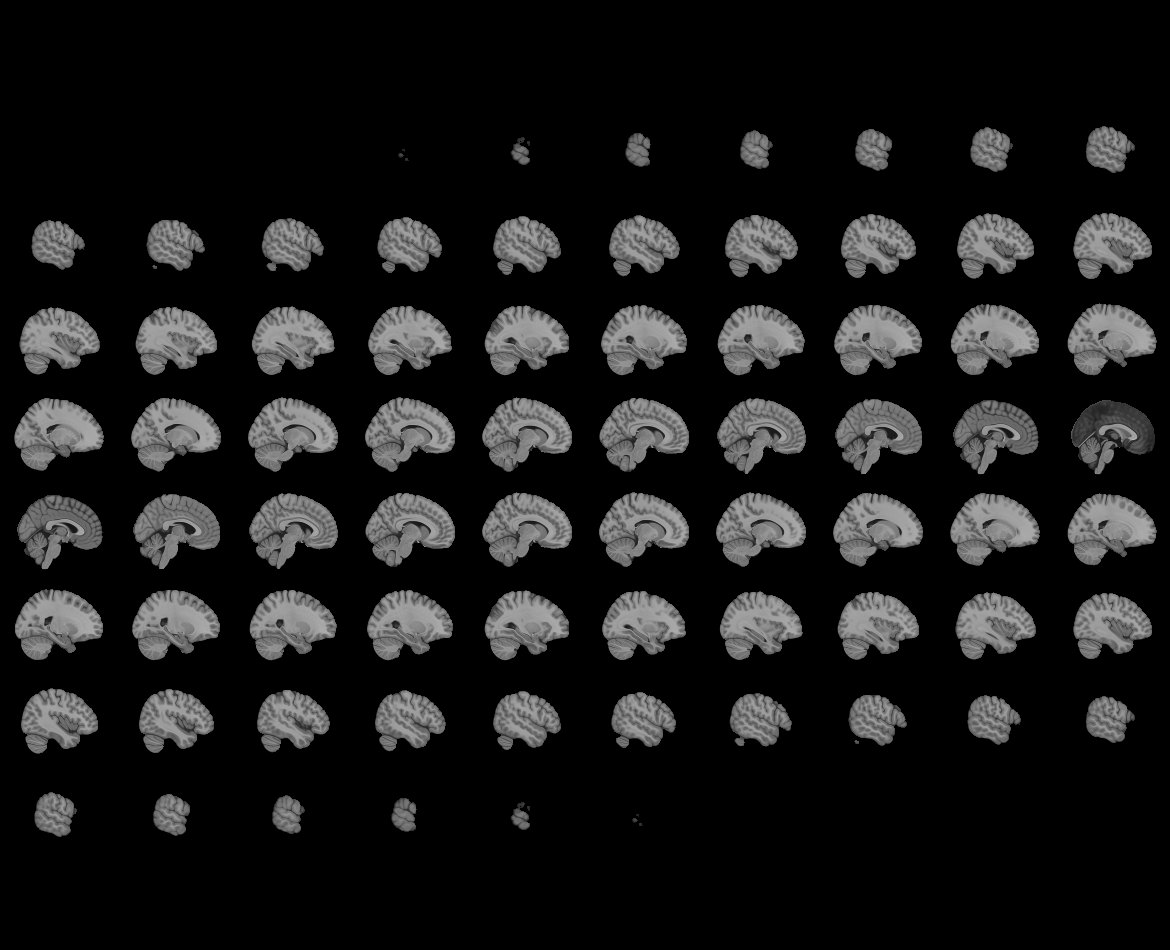
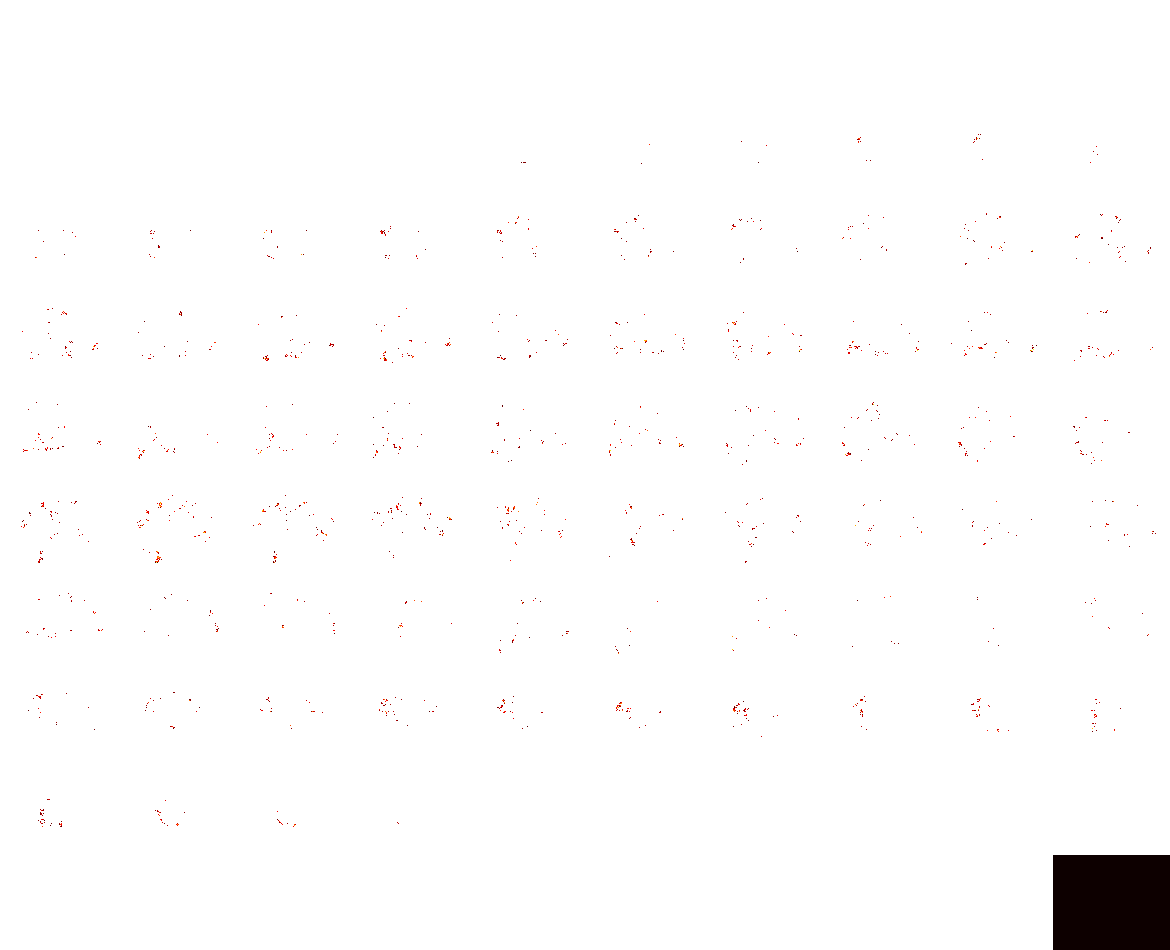

In [49]:
 plotting.view_img(log_pvals_permuted_ols_unmasked,
                  threshold=threshold)

### Non-Mandarin speaking group:

In [36]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(l1_fnames, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[0,1],
                             n_perm=1000,
                             n_jobs=1)

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: divide by zero encountered in true_divide
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: invalid value encountered in sqrt
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)


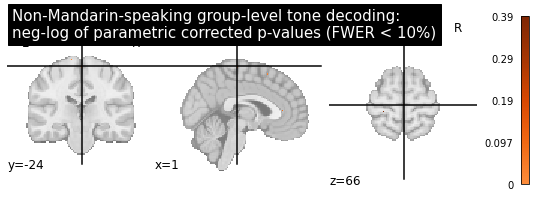

In [37]:
threshold = 1.
title = ('Non-Mandarin-speaking group-level tone decoding: \n'
         'neg-log of parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, colorbar=True, 
                       #threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

### Group differences

In [39]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(l1_fnames_groupdiff, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[1, 0], #'group',
                             n_perm=1000,
                             n_jobs=1)

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: divide by zero encountered in true_divide
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)


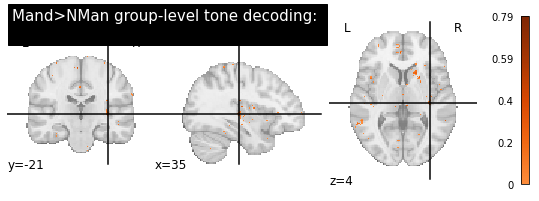

In [41]:
threshold = 1.0
title = ('Mand>NMan group-level tone decoding: \n'
         #'neg-log of parametric corrected p-values (FWER < 10%)'
        )
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, colorbar=True, 
                       #threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



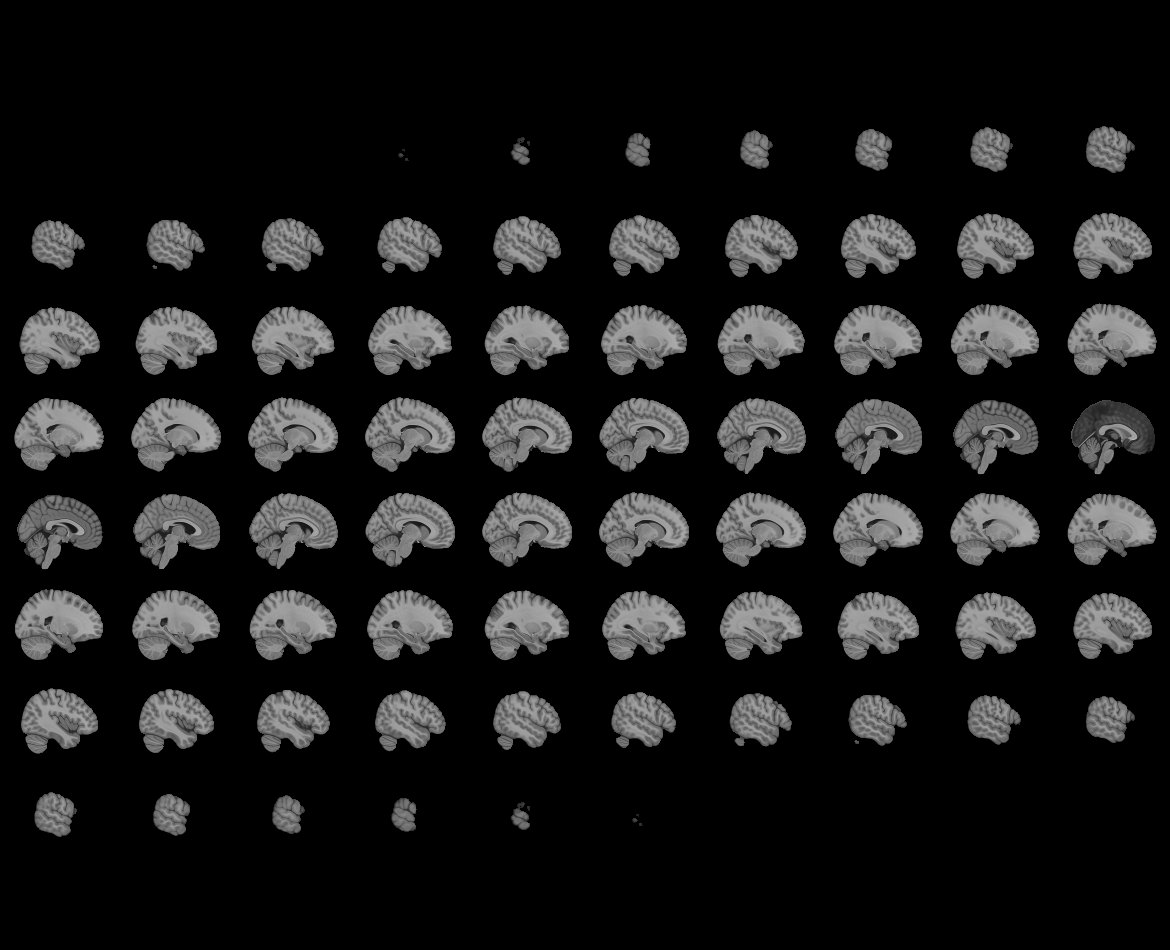
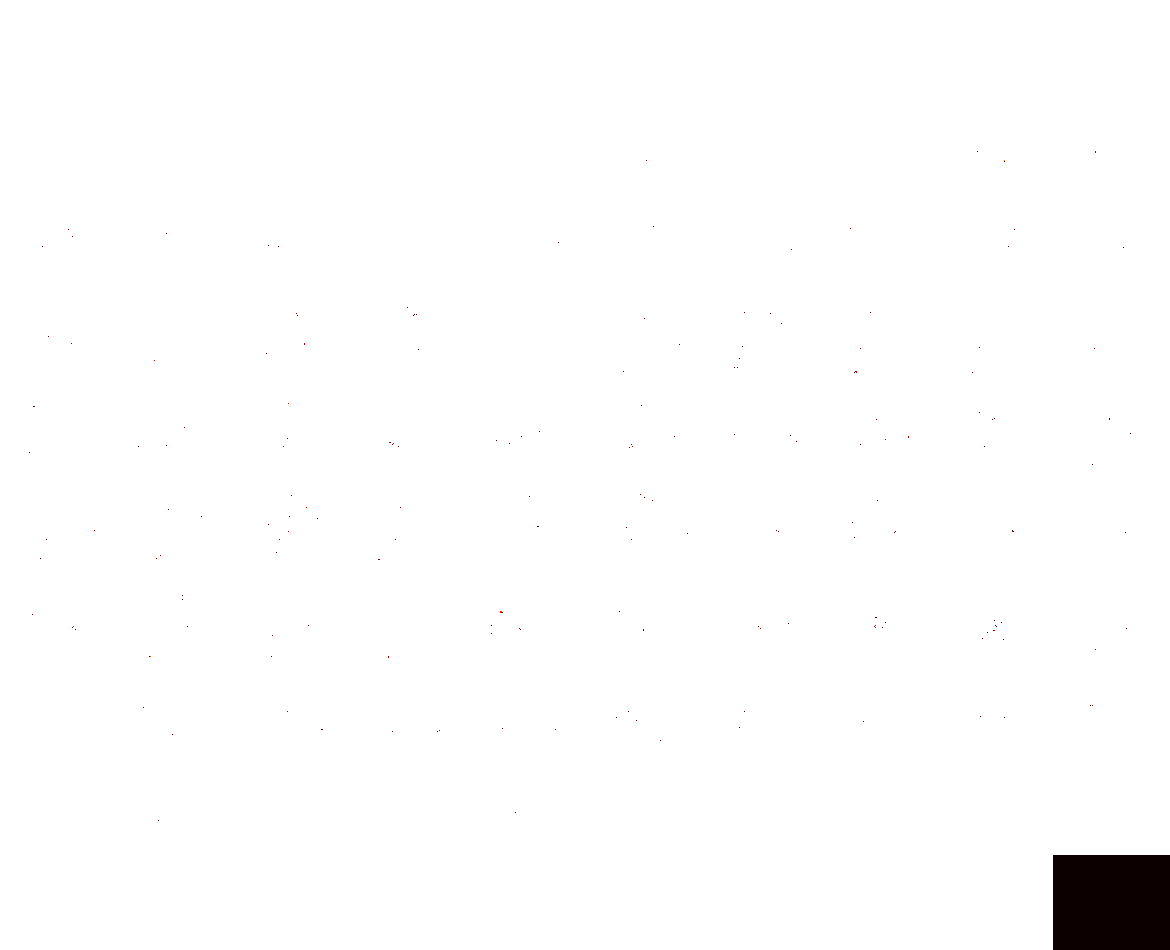

In [44]:
plotting.view_img(log_pvals_permuted_ols_unmasked, 
                  threshold=0.1, 
                  cut_coords=[17,12,5],
                  title='Mand > NMan classification')